# Clean- DMS Data with Sb Sound Rule

Goal: get a cleaned dataset of animals I trained to fixate with novel curriculum that went on to attempt to learn DMS. Specifically focusing on stage 11 when they are doing a simple 2 stimulus set sound rule which requires discriminating the second sound.

Specifics

- need to remove anaimals that have sa sound rule (2-3 of them)
- need to clean up dates, some training happened around christmas break and there are stage swithces to get animals back on
- need to ensure there is no give
- want to remove any abnormal sessions (all violations, low hits, low trials etc)
- need to remove any animals that have an atypical fixation growth curriculum. ie it's not clear what value they grew to and can't be confirmed to be exactly like V2 in the paper


In [1]:
import seaborn as sns
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import config as c

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")


DATA_PATH = "data/dms_sb_tdf.parquet"

# 0. Load Data


In [2]:
tdf = pd.read_parquet(DATA_PATH)
tdf["dt_date"]=  pd.to_datetime(tdf['date'])
tdf["session"] = tdf.groupby("animal_id")["dt_date"].transform(
    lambda x: (x - x.min()).dt.days + 1
)
tdf["cumulative_trial"] = tdf.groupby("animal_id").cumcount() + 1


df = tdf.copy()
df.head()

trial animal_id        date  sess_id  hits  violations  stage    sa    sb  \
0    121      R010  2023-08-15   924935     1           0    5.0   3.0   3.0   
1    122      R010  2023-08-15   924935     1           0    5.0  12.0  12.0   
2    123      R010  2023-08-15   924935     1           0    5.0   3.0   3.0   
3    124      R010  2023-08-15   924935     1           0    5.0   3.0   3.0   
4    125      R010  2023-08-15   924935     1           0    5.0   3.0   3.0   

  stimuli_on  ...  pre_go_dur  sound_pair  give_type_imp  give_frac  \
0      False  ...        0.45    3.0, 3.0           none        1.0   
1      False  ...        0.45  12.0, 12.0           none        1.0   
2      False  ...        0.45    3.0, 3.0           none        1.0   
3      False  ...        0.45    3.0, 3.0           none        1.0   
4      False  ...        0.45    3.0, 3.0           none        1.0   

   n_settling_ins  avg_settling_in  cpoke_dur    dt_date  session  \
0             NaN              NaN       <NA> 2023-08-15        1   
1             NaN              NaN       <NA> 2023-08-15        1   
2             NaN              NaN       <NA> 2023-08-15        1   
3             NaN              NaN       <NA> 2023-08-15        1   
4             NaN              NaN       <NA> 2023-08-15        1   

   cumulative_trial  
0                 1  
1                 2  
2                 3  
3                 4  
4                 5  

[5 rows x 29 columns]

# 1. Basic Cleaning

Filter data from previous go guide curriculum that also had center poiking
based on sessions table, this ended on 2023-08-25 for the three animals I tried
it with and they all went back to side poking stage 3

R036 had a bad rig or something and started in stage 5 before going back to spoking and switching rigs. I want to remove the sessions before spoking because they are not representative of this animals performance in this stage.


In [3]:
go_guide_date_min = "2023-08-25"
go_guide_animals = ["R010", "R011", "R012"]

# Create boolean masks
mask_go_guide = (df["animal_id"].isin(go_guide_animals)) & (
    df["dt_date"] > go_guide_date_min
)
mask_other_animals = ~df["animal_id"].isin(go_guide_animals)

# Combine masks to retain all data
combined_mask = mask_go_guide | mask_other_animals

df = df[combined_mask]

In [4]:
animal_to_adjust = ["R036"]
adjusted_start_date = "2024-01-22"

# Create boolean masks
mask_r036 = (df["animal_id"].isin(animal_to_adjust)) & (
    df["dt_date"] >= adjusted_start_date
)
mask_other_animals = ~df["animal_id"].isin(animal_to_adjust)

# Combine masks to retain all data
combined_mask = mask_r036 | mask_other_animals

df = df[combined_mask]

# 2. Find Valid Dates Given Hit Rate, Give Type


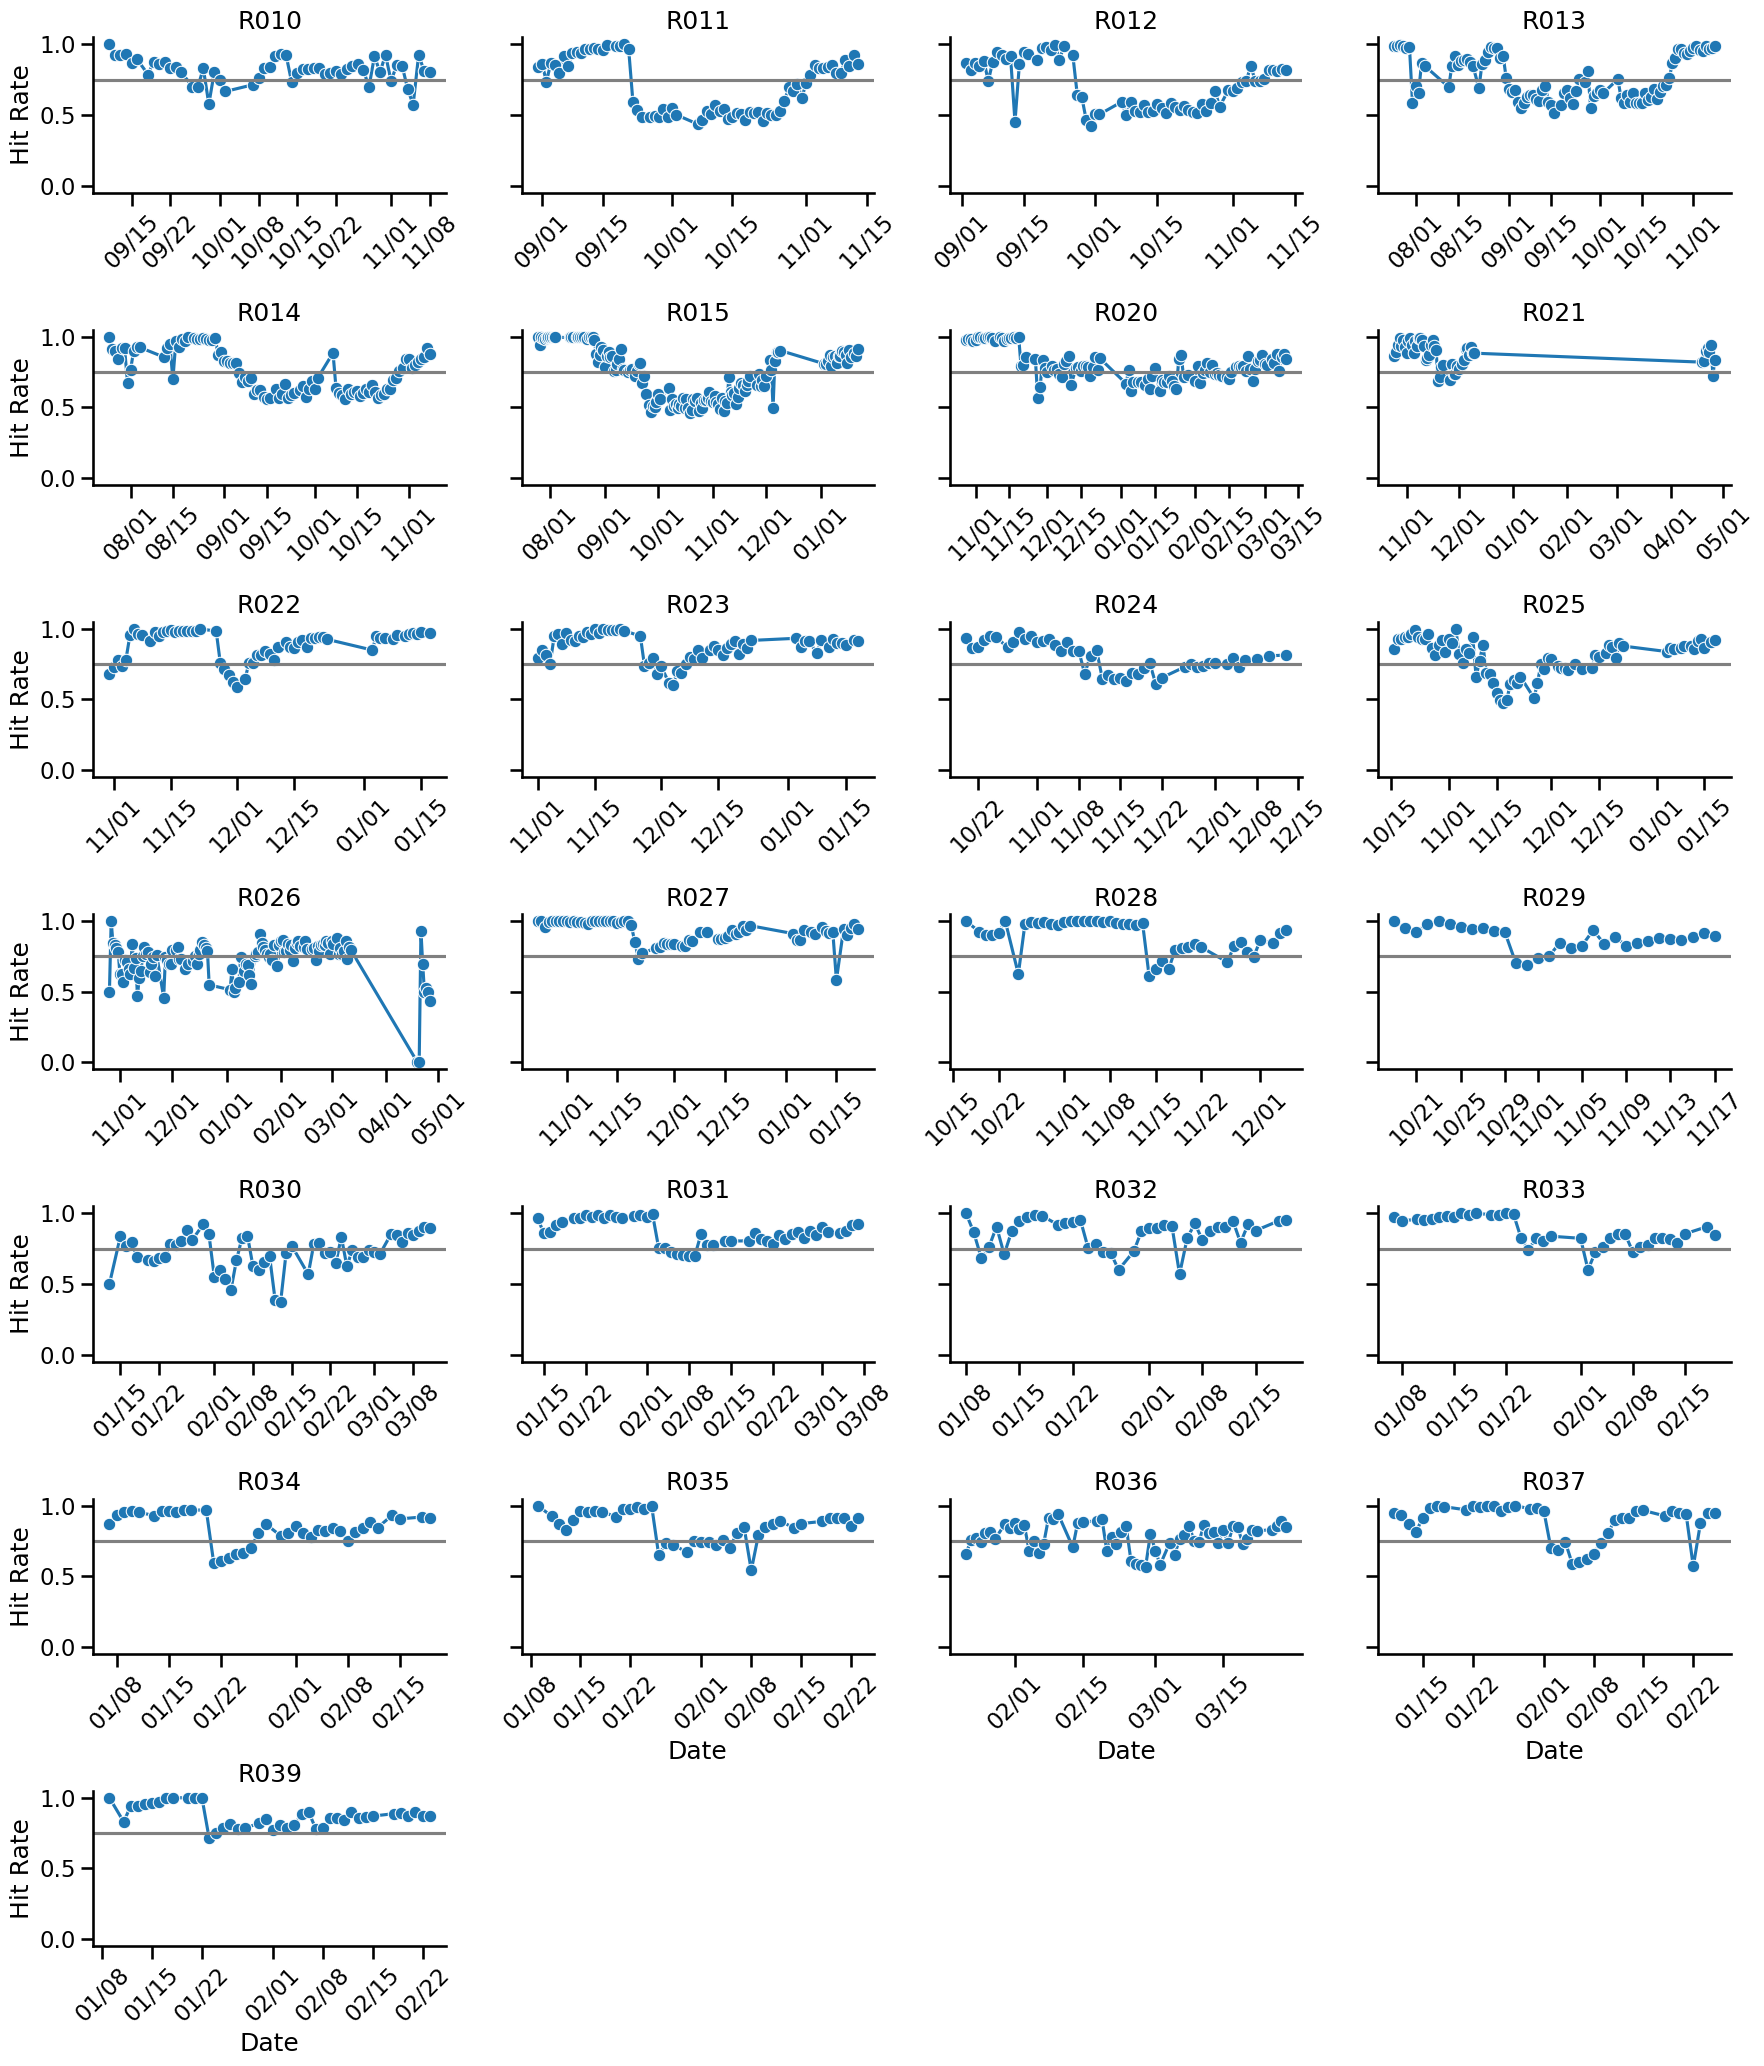

In [5]:
hit_rate_df = (
    df
    .groupby(['animal_id', 'dt_date']).hits.mean()
    .reset_index().rename(columns={"hits":"hit_rate"})
)
hit_rate_df
g = sns.relplot(
    data=hit_rate_df,
    x='dt_date',            # our datetime axis
    y='hit_rate',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Hit Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.axhline(0.75, color='gray') # add horizontal line at 0.75
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()

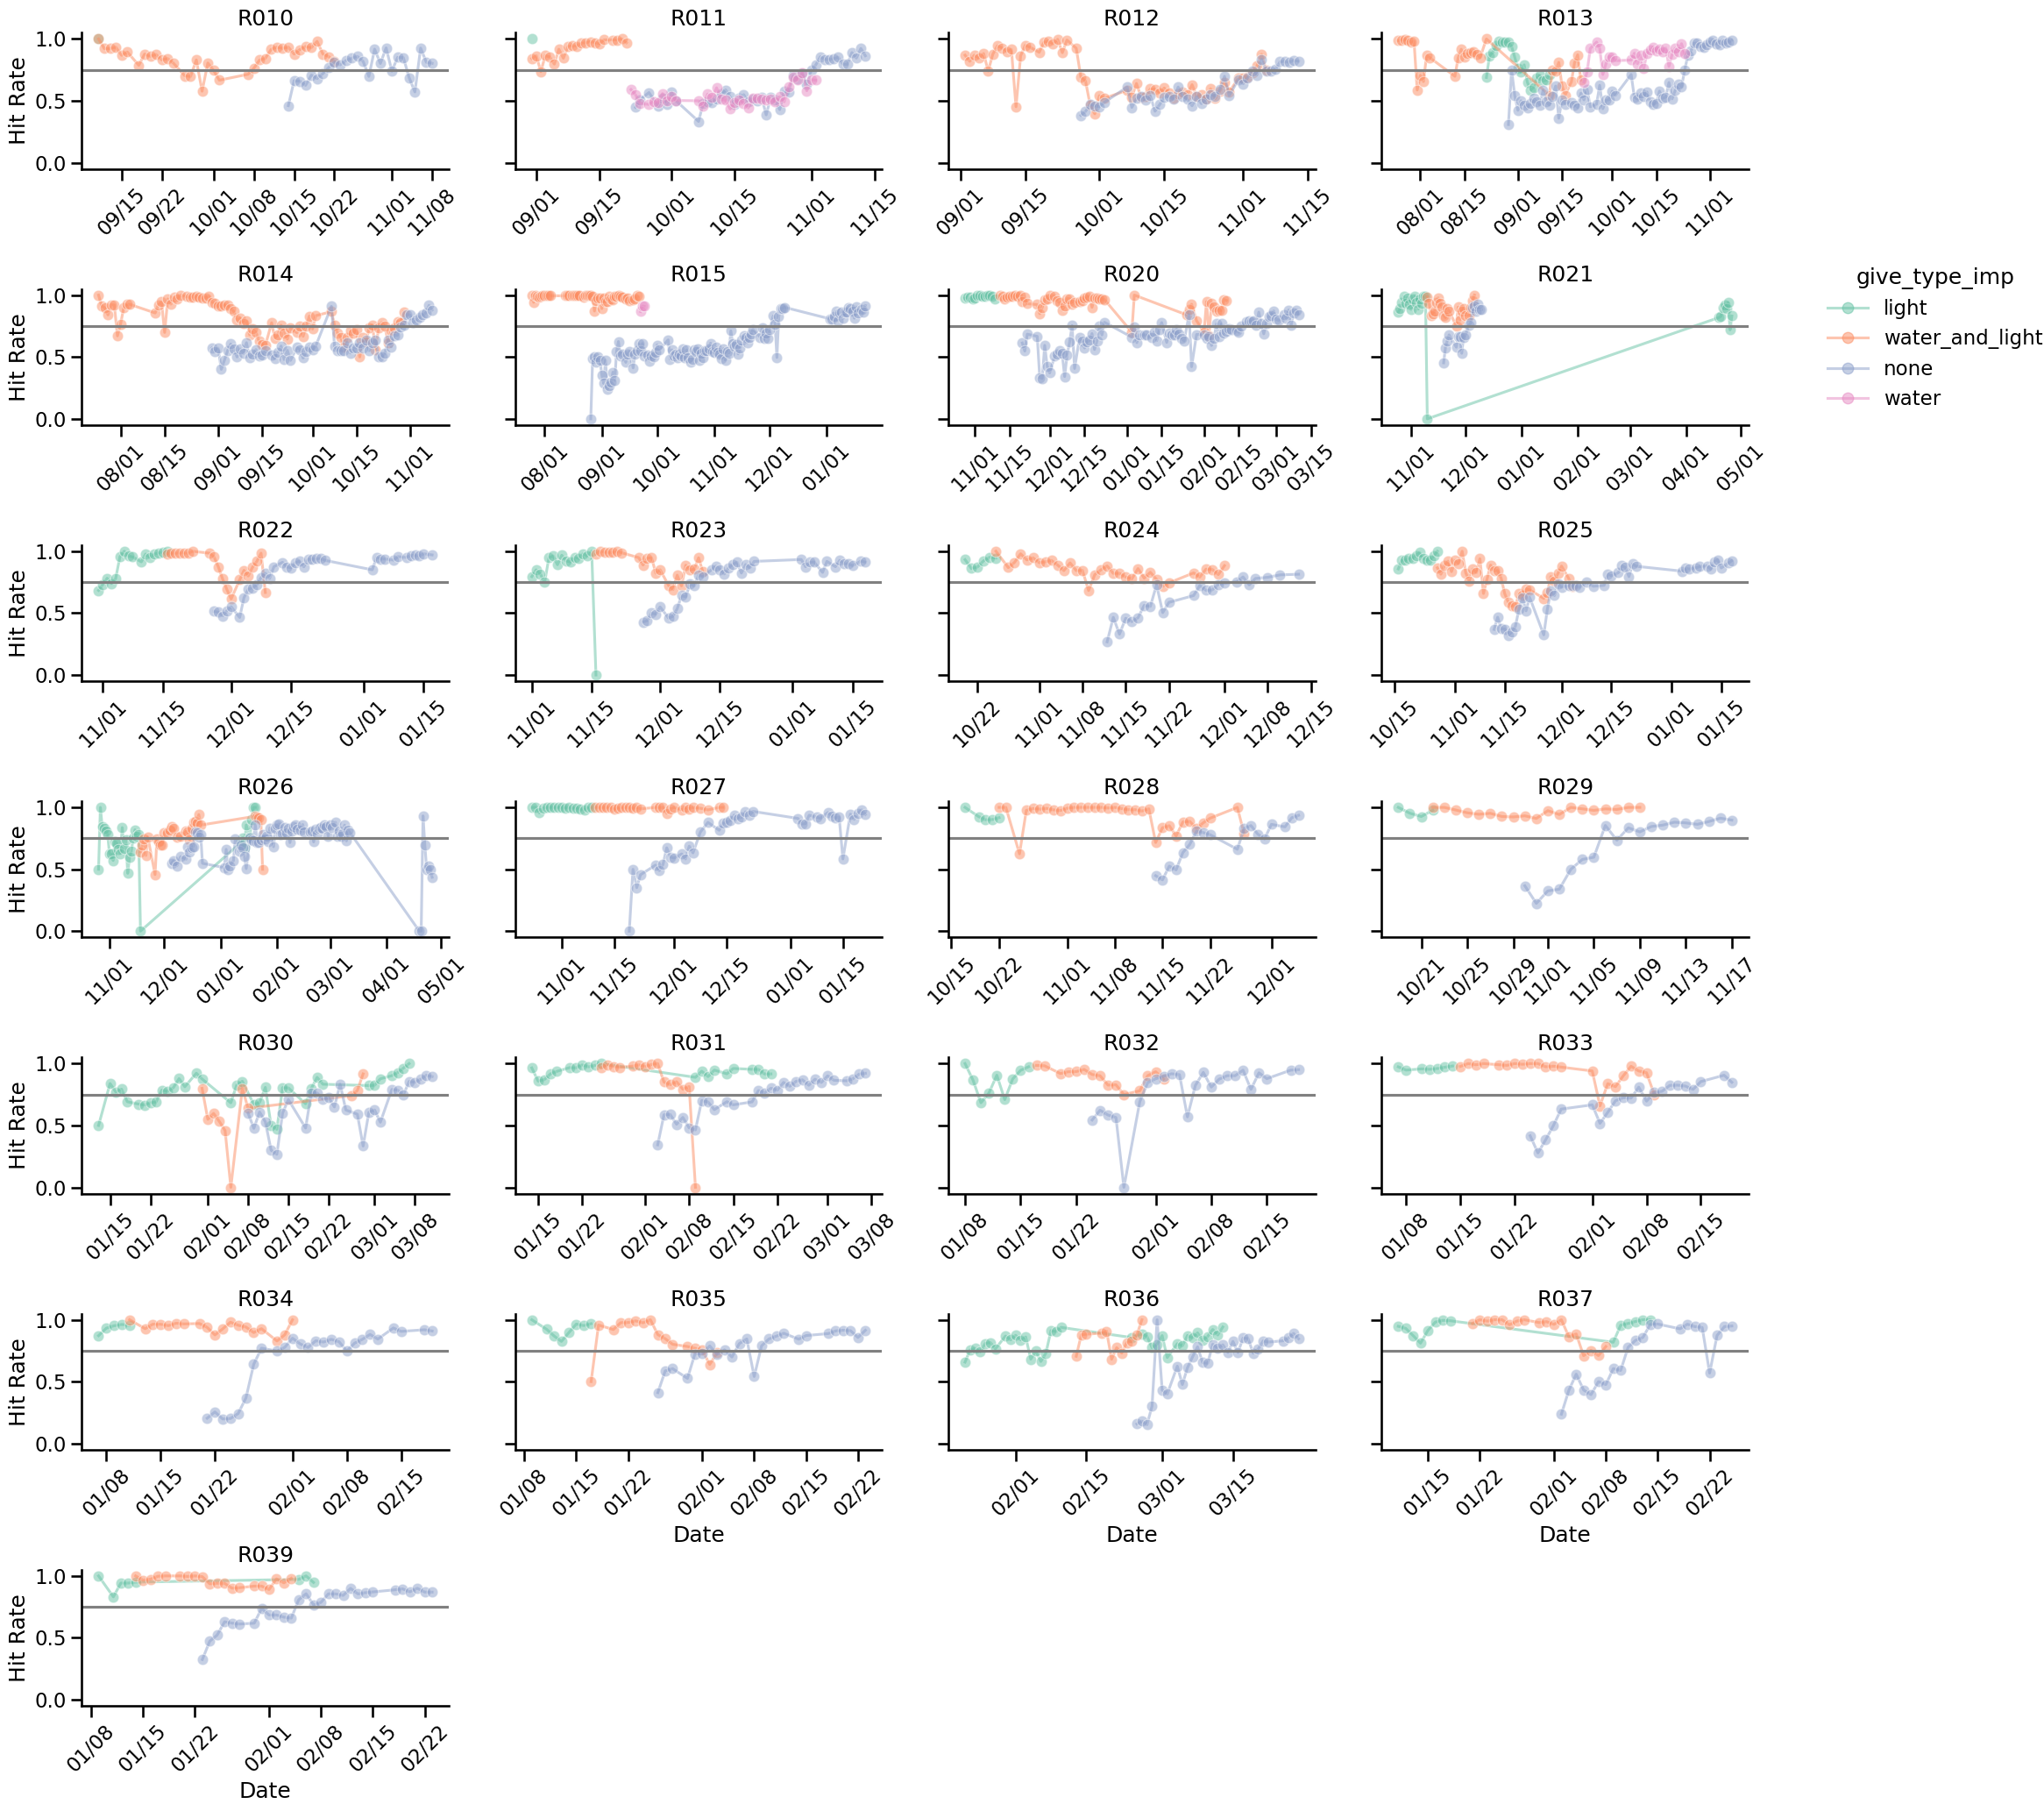

In [6]:

hit_rate_df = (
    df
    .groupby(['animal_id', 'dt_date', 'give_type_imp']).hits.mean()
    .reset_index().rename(columns={"hits":"hit_rate"})
)

g = sns.relplot(
    data=hit_rate_df,
    x='dt_date',            # our datetime axis
    y='hit_rate',        # the value we want to plot
    kind='line',         # line plot
    hue='give_type_imp',
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
    palette=sns.color_palette("Set2", 4),
    alpha=0.5
)

# Beautify:
g.set_axis_labels("Date", "Hit Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.axhline(0.75, color='gray') # add horizontal line at 0.75
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Move the legend outside of the plot
g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

plt.tight_layout()

In [7]:
import pandas as pd

# ensure your date column is really datetime
df['dt_date'] = pd.to_datetime(df['dt_date'])

# cut‐off dates for “keep only after”
after_cutoffs = {
    'R026': pd.Timestamp('2024-01-15'), # re-trained after christmas break
    'R015': pd.Timestamp('2024-01-01'), # re-trained after christmas break
    'R020': pd.Timestamp('2024-02-01'), # re-trained after christmas break
    'R030': pd.Timestamp('2024-03-01'), # re-trained after christmas break
}

# cut‐off dates for “keep only before”
before_cutoffs = {
    'R010': pd.Timestamp('2023-11-03'), # stopped doing task 
    'R021': pd.Timestamp('2024-04-01'), # reset
}

# mask for those animals that need “> cutoff”
mask_after = (
    df['animal_id'].isin(after_cutoffs) &
    (df['dt_date'] > df['animal_id'].map(after_cutoffs))
)

# mask for those animals that need “< cutoff”
mask_before = (
    df['animal_id'].isin(before_cutoffs) &
    (df['dt_date'] < df['animal_id'].map(before_cutoffs))
)

# everyone else: no date filter
mask_other = ~df['animal_id'].isin(set(after_cutoffs) | set(before_cutoffs))

# final filtered df
df_filtered = df[mask_after | mask_before | mask_other]

# remove give
df_filtered = df_filtered.query("give_type_imp == 'none'") # no give

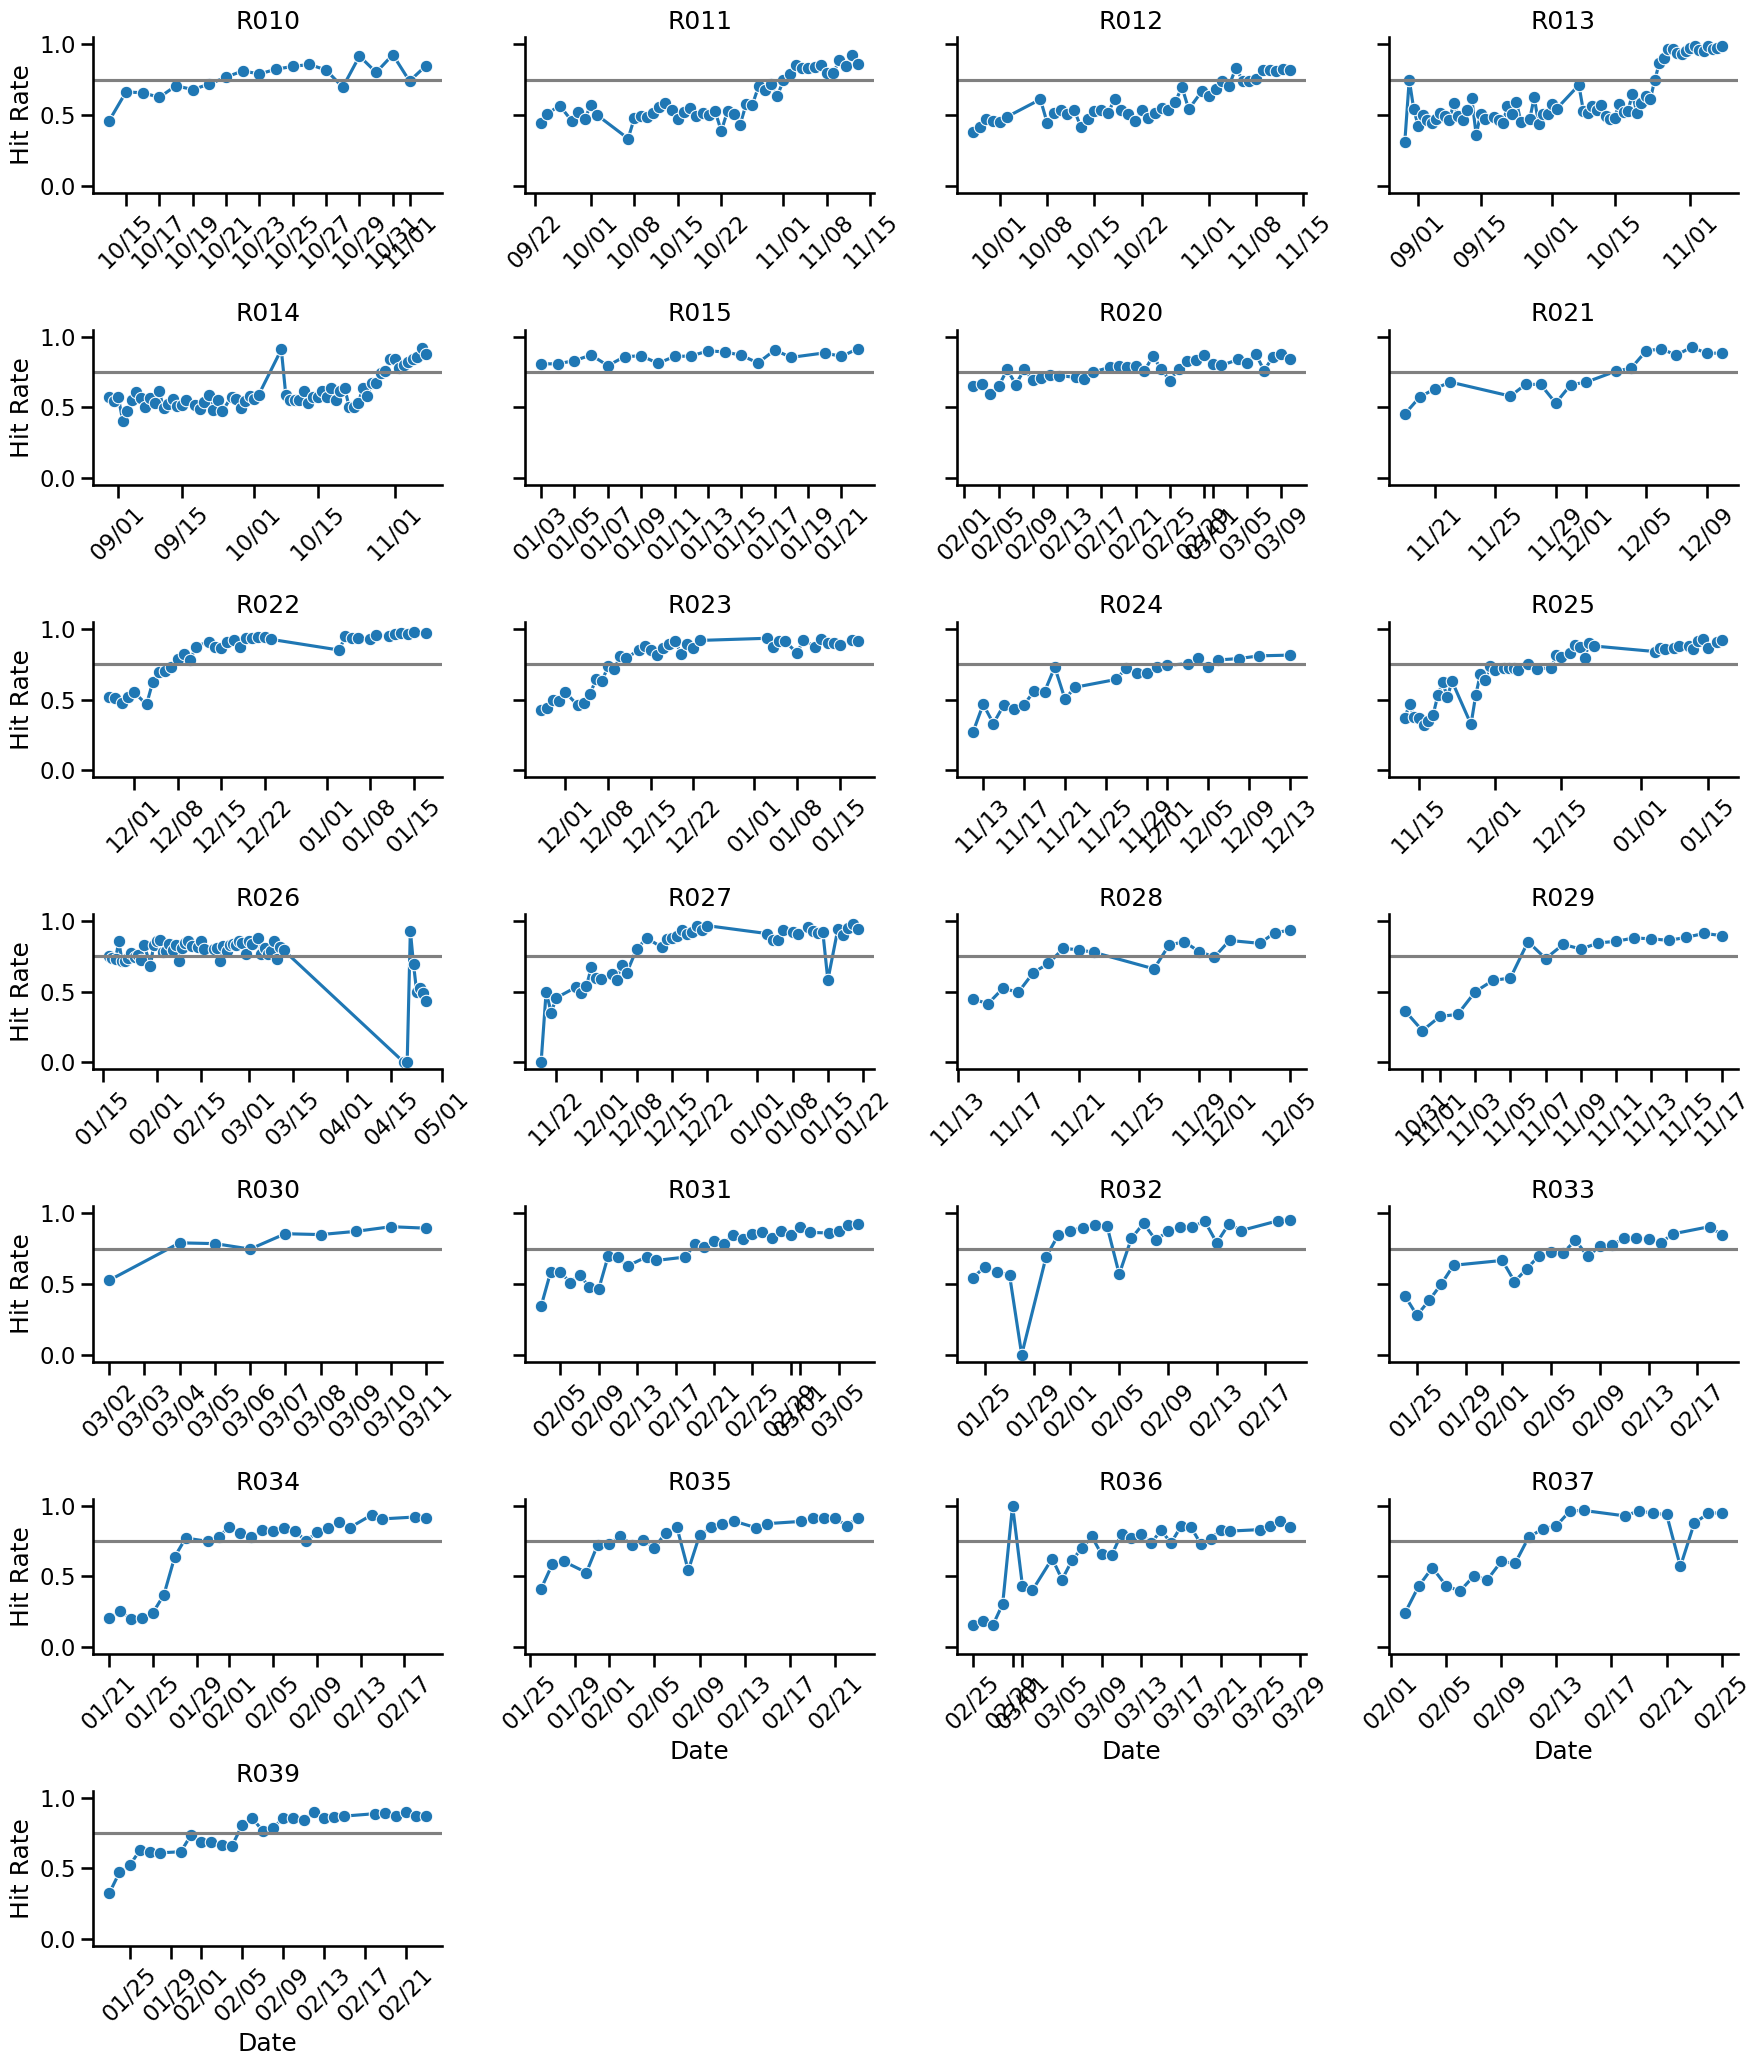

In [8]:


hit_rate_df = (
    df_filtered
    .groupby(['animal_id', 'dt_date']).hits.mean()
    .reset_index().rename(columns={"hits":"hit_rate"})
)

g = sns.relplot(
    data=hit_rate_df,
    x='dt_date',            # our datetime axis
    y='hit_rate',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Hit Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.axhline(0.75, color='gray') # add horizontal line at 0.75
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_62728/2964930595.py:7: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  g = sns.relplot(


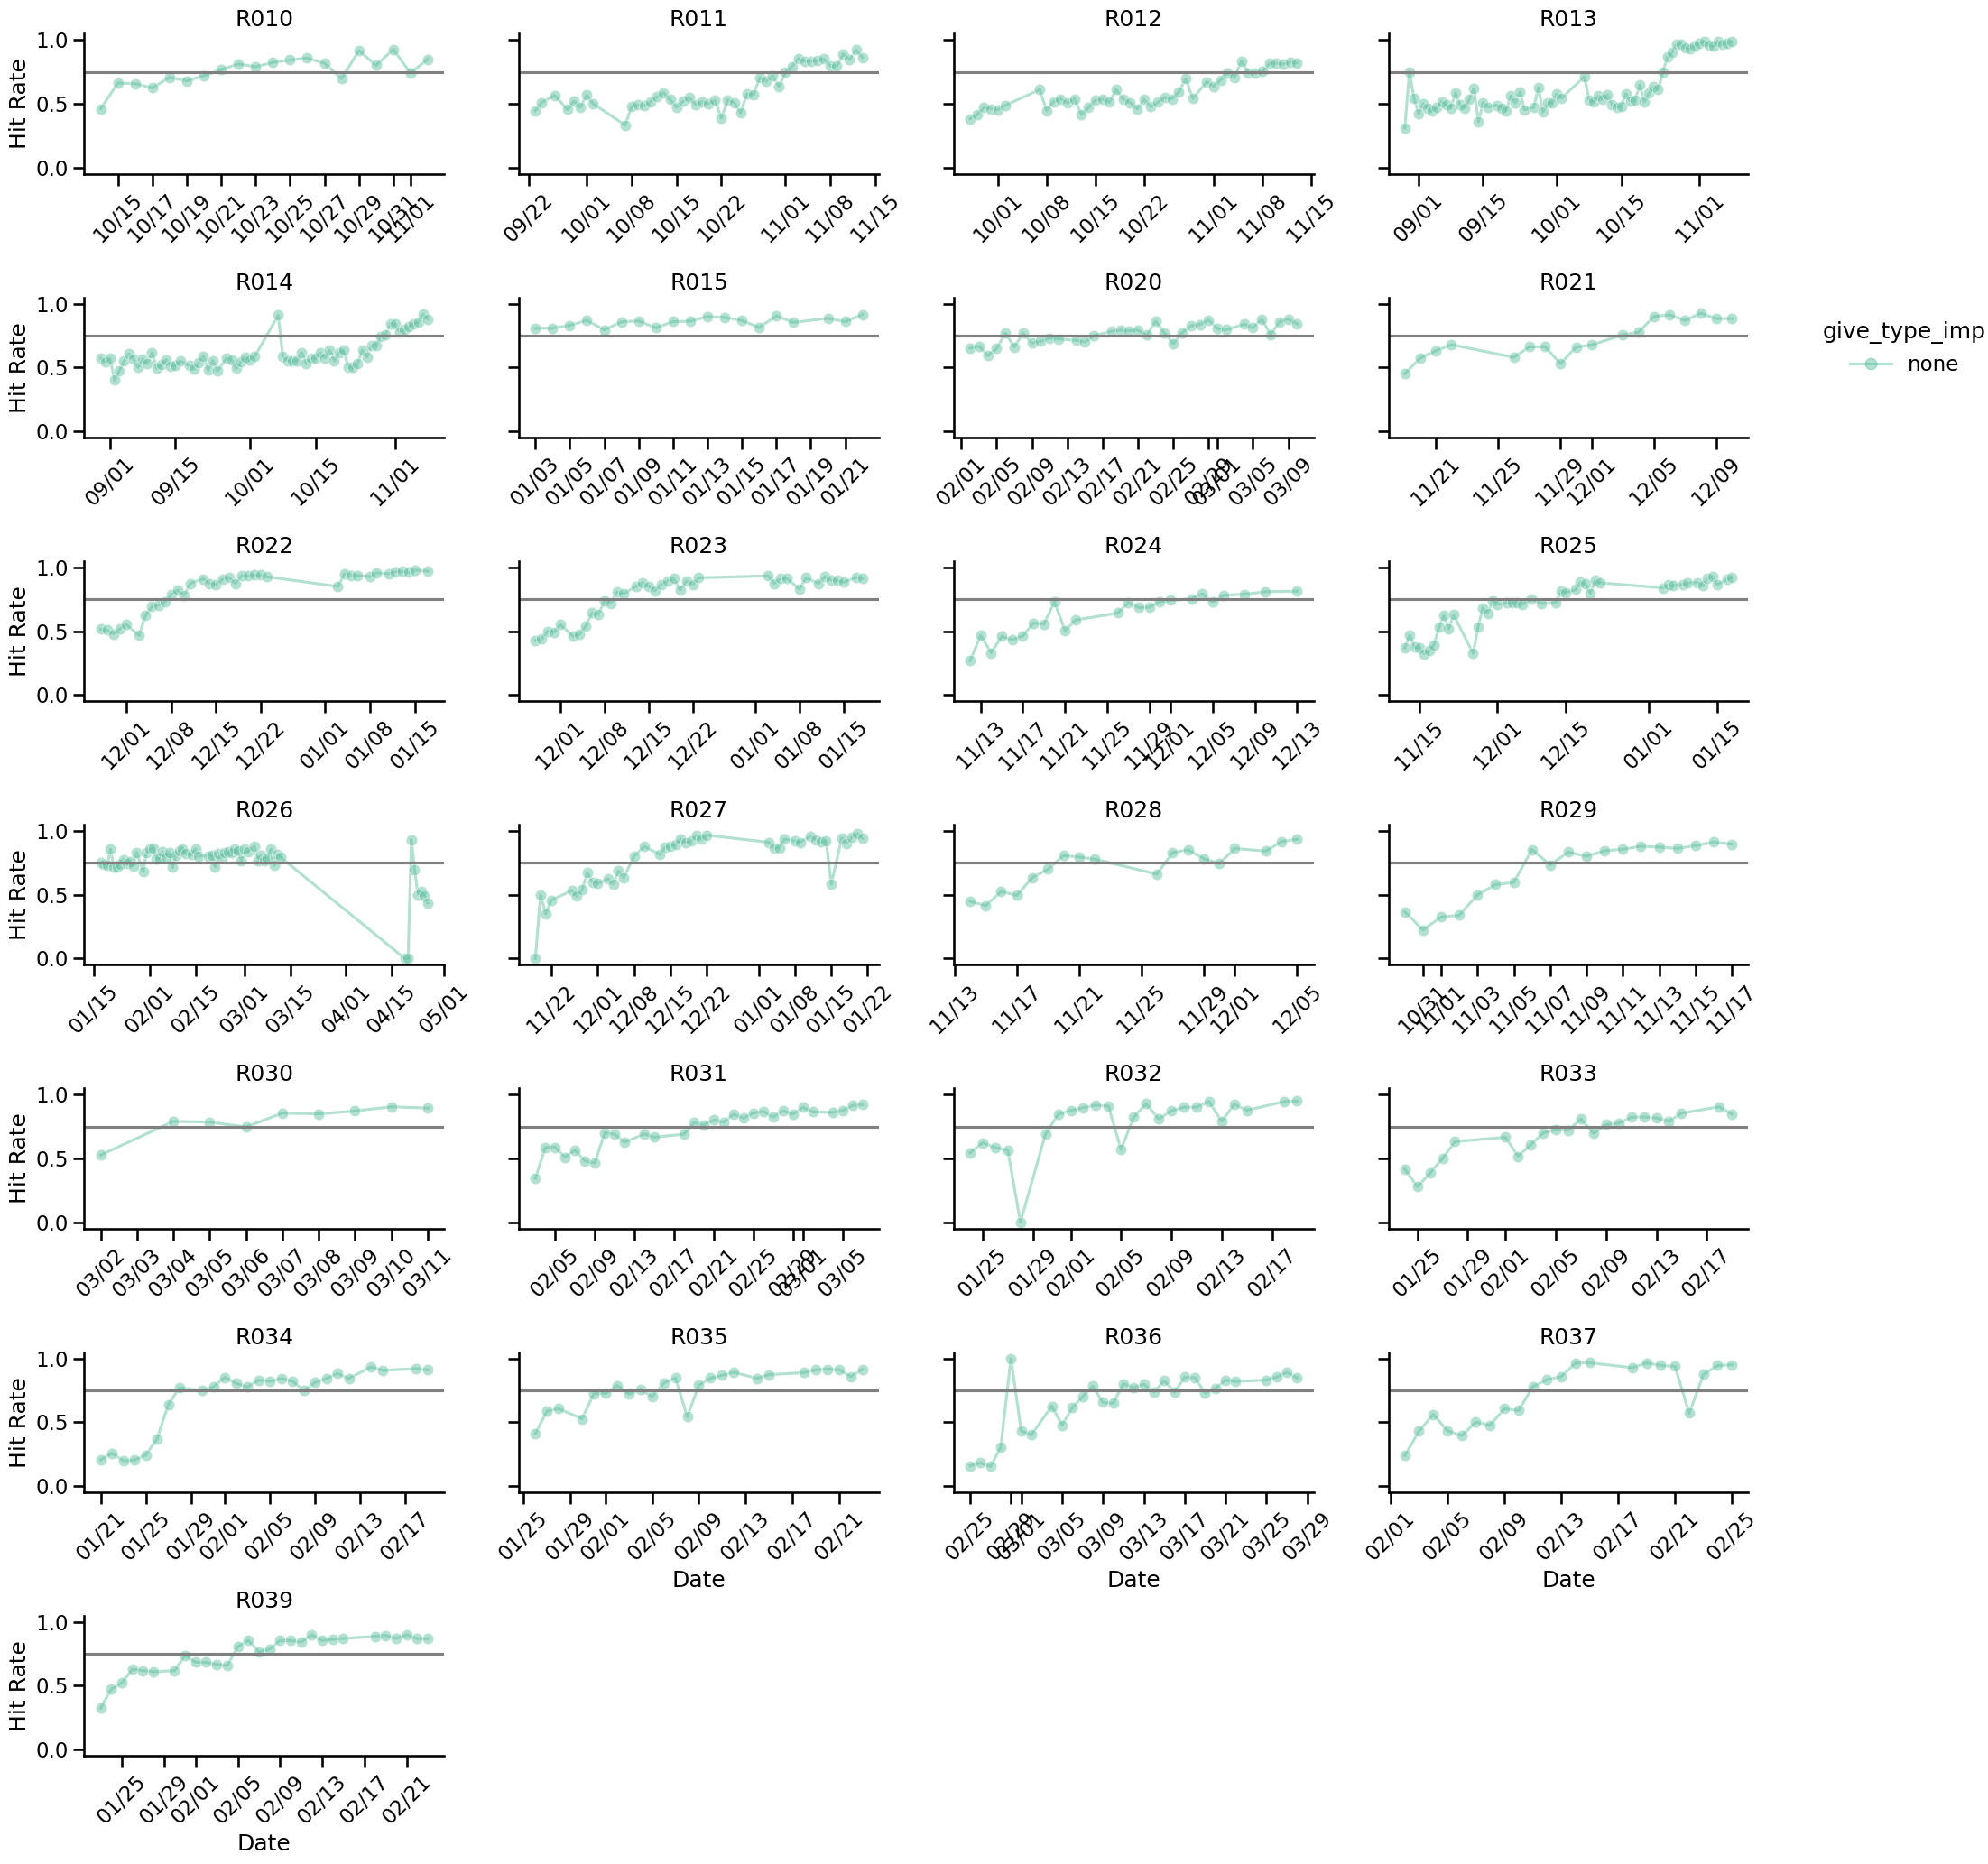

In [9]:

hit_rate_df = (
    df_filtered
    .groupby(['animal_id', 'dt_date', 'give_type_imp']).hits.mean()
    .reset_index().rename(columns={"hits":"hit_rate"})
)

g = sns.relplot(
    data=hit_rate_df,
    x='dt_date',            # our datetime axis
    y='hit_rate',        # the value we want to plot
    kind='line',         # line plot
    hue='give_type_imp',
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
    palette=sns.color_palette("Set2", 4),
    alpha=0.5
)

# Beautify:
g.set_axis_labels("Date", "Hit Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.axhline(0.75, color='gray') # add horizontal line at 0.75
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Move the legend outside of the plot
g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

plt.tight_layout()

> Great, now we have stable performance and no give.


# 3. Remove Sa Rule and Second Stim Set Sb Rule Animals

These are the animals with stim pairs 12-3 and 3-3, so the task they have is different. There are also some sb rule animals with stim pairs 12-3 12-12 and we will remove those.


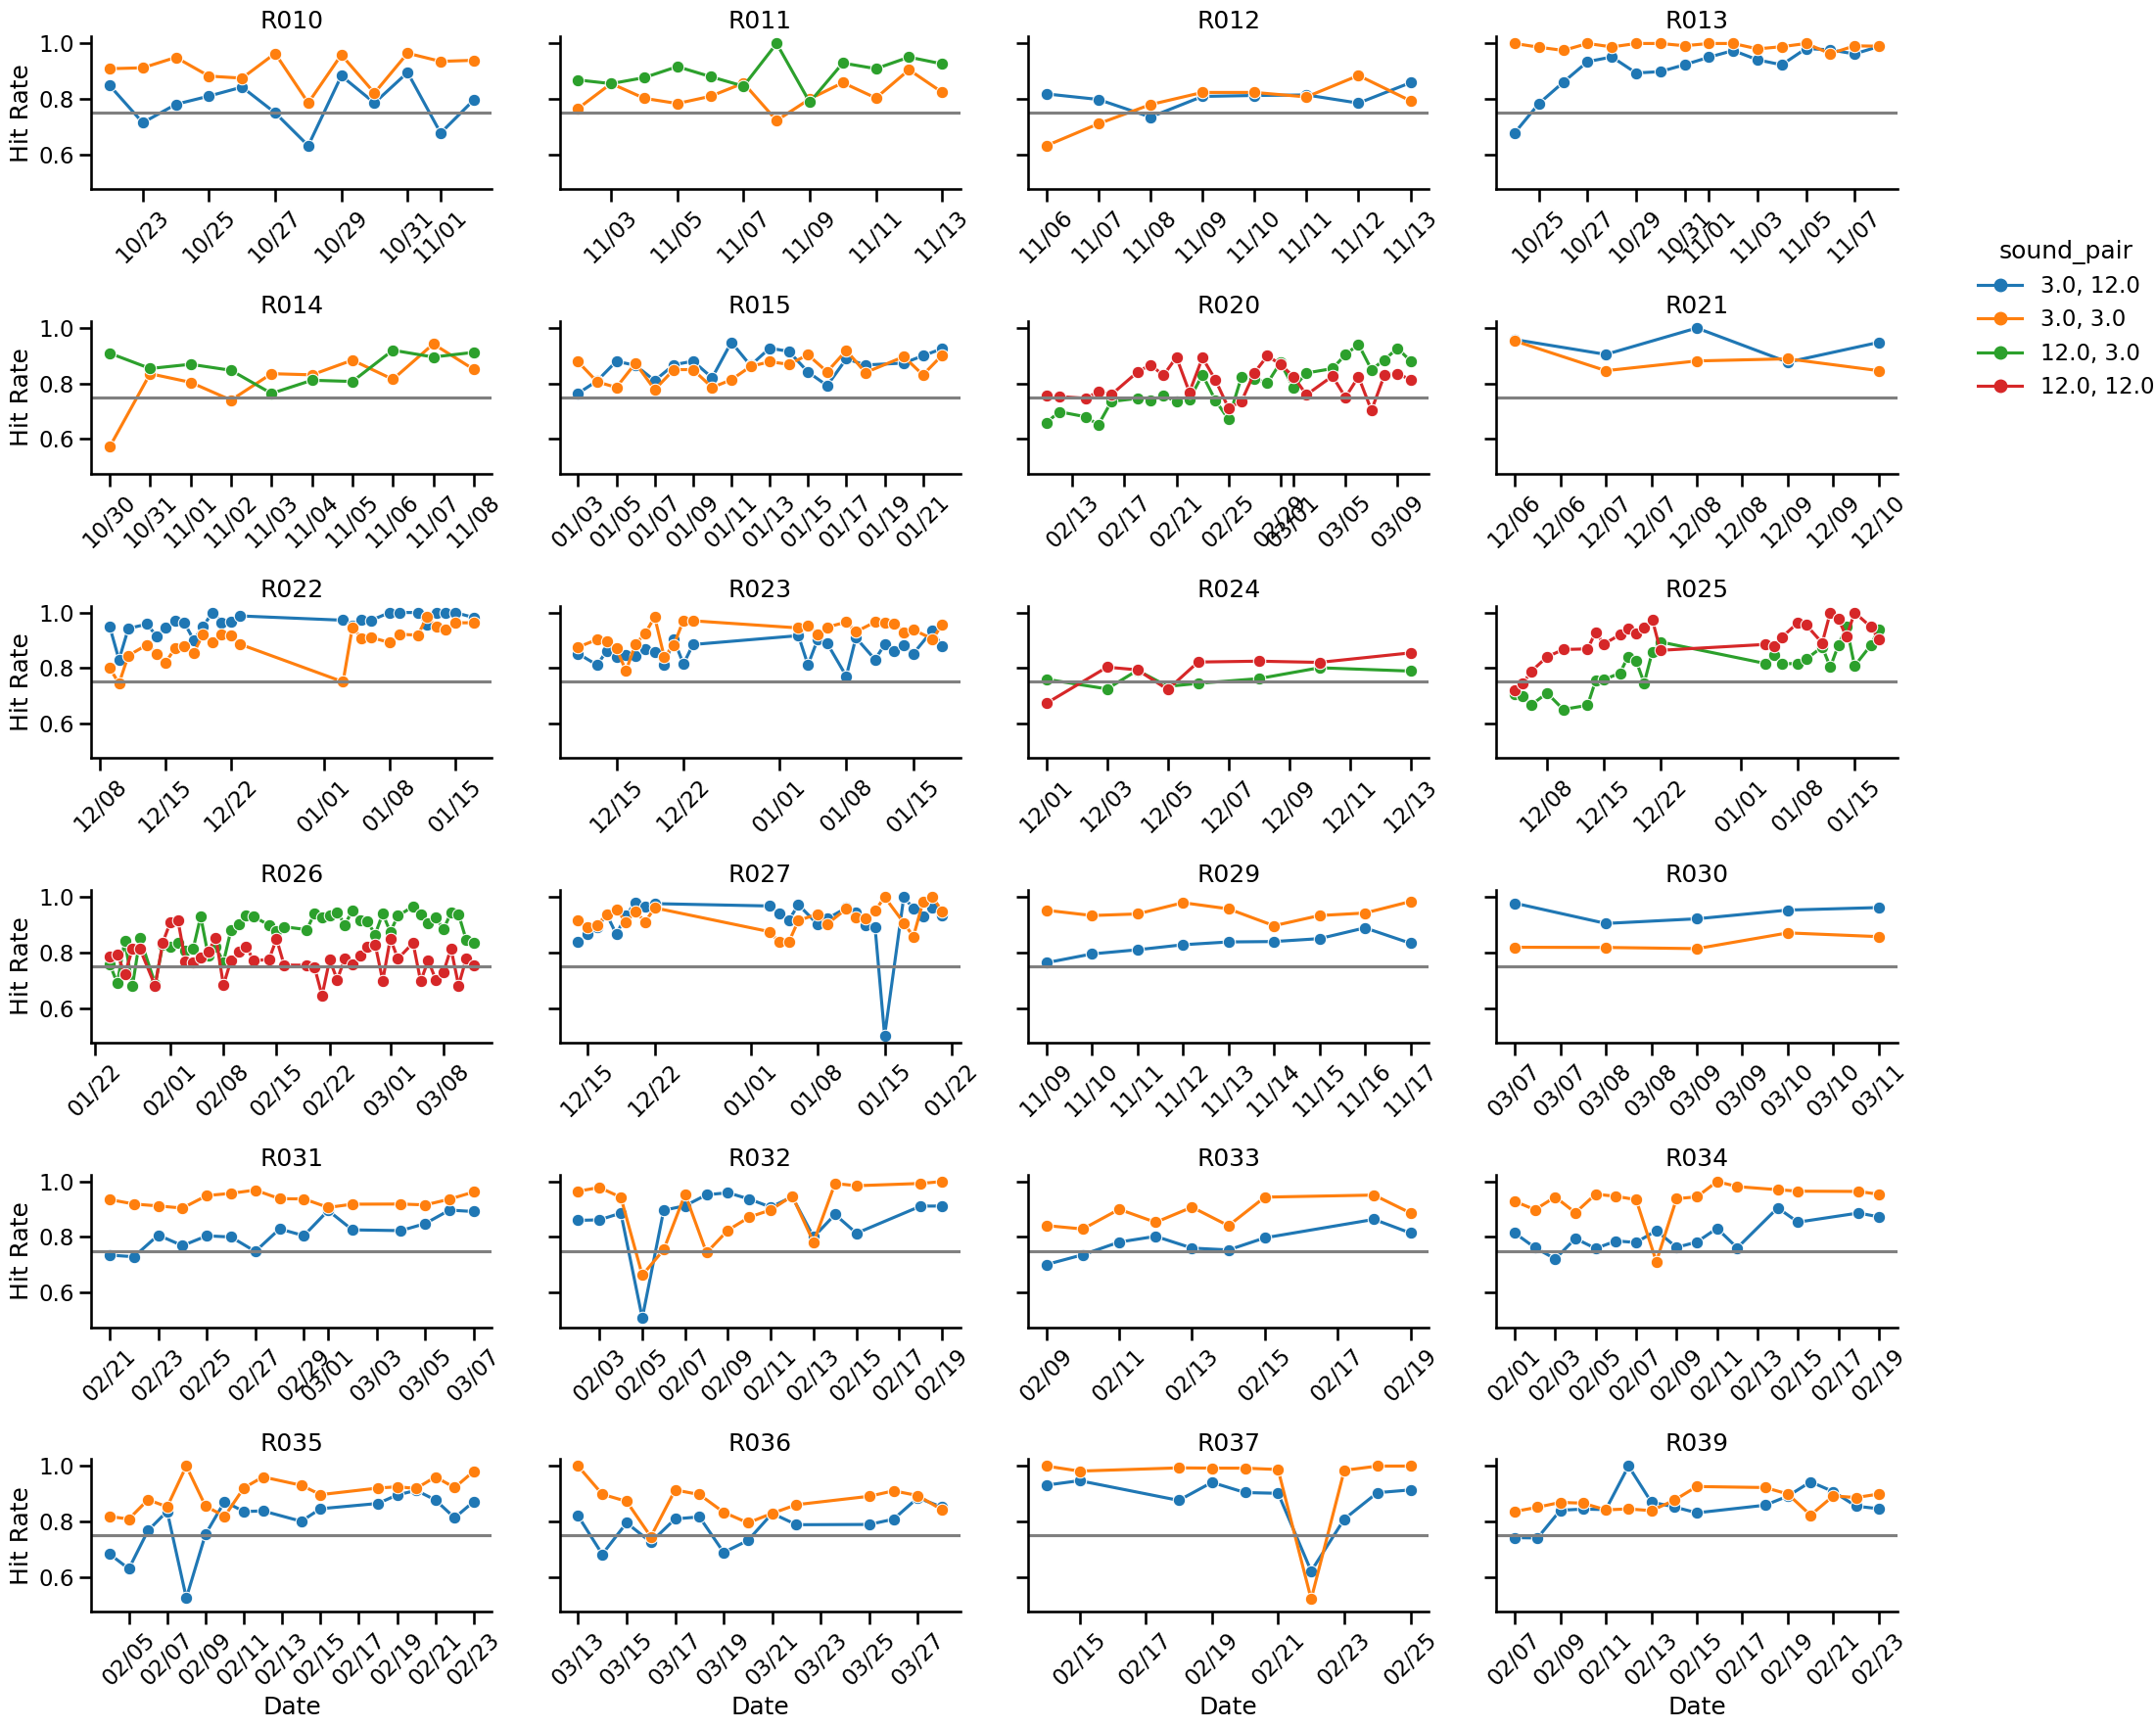

In [10]:

hit_rate_df = (
    df_filtered.query("stage == 11")
    .groupby(['animal_id', 'dt_date', 'sound_pair']).hits.mean()
    .reset_index().rename(columns={"hits":"hit_rate"})
)

g = sns.relplot(
    data=hit_rate_df,
    x='dt_date',            # our datetime axis
    y='hit_rate',        # the value we want to plot
    kind='line',         # line plot
    hue='sound_pair',
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Hit Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.axhline(0.75, color='gray') # add horizontal line at 0.75
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Move the legend outside of the plot
g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

plt.tight_layout()

In [11]:
SA_ANIMALS = ['R014','R011']
SB_SET_2_ANIMALS =['R020', 'R024', 'R025', 'R026']
df_filtered = df_filtered.query("animal_id not in @SA_ANIMALS and animal_id not in @SB_SET_2_ANIMALS") 

# 4. Various EDA


## Post Stim Duration

Remove any animals that don't have a consistent post sb delay of 0.45 seconds


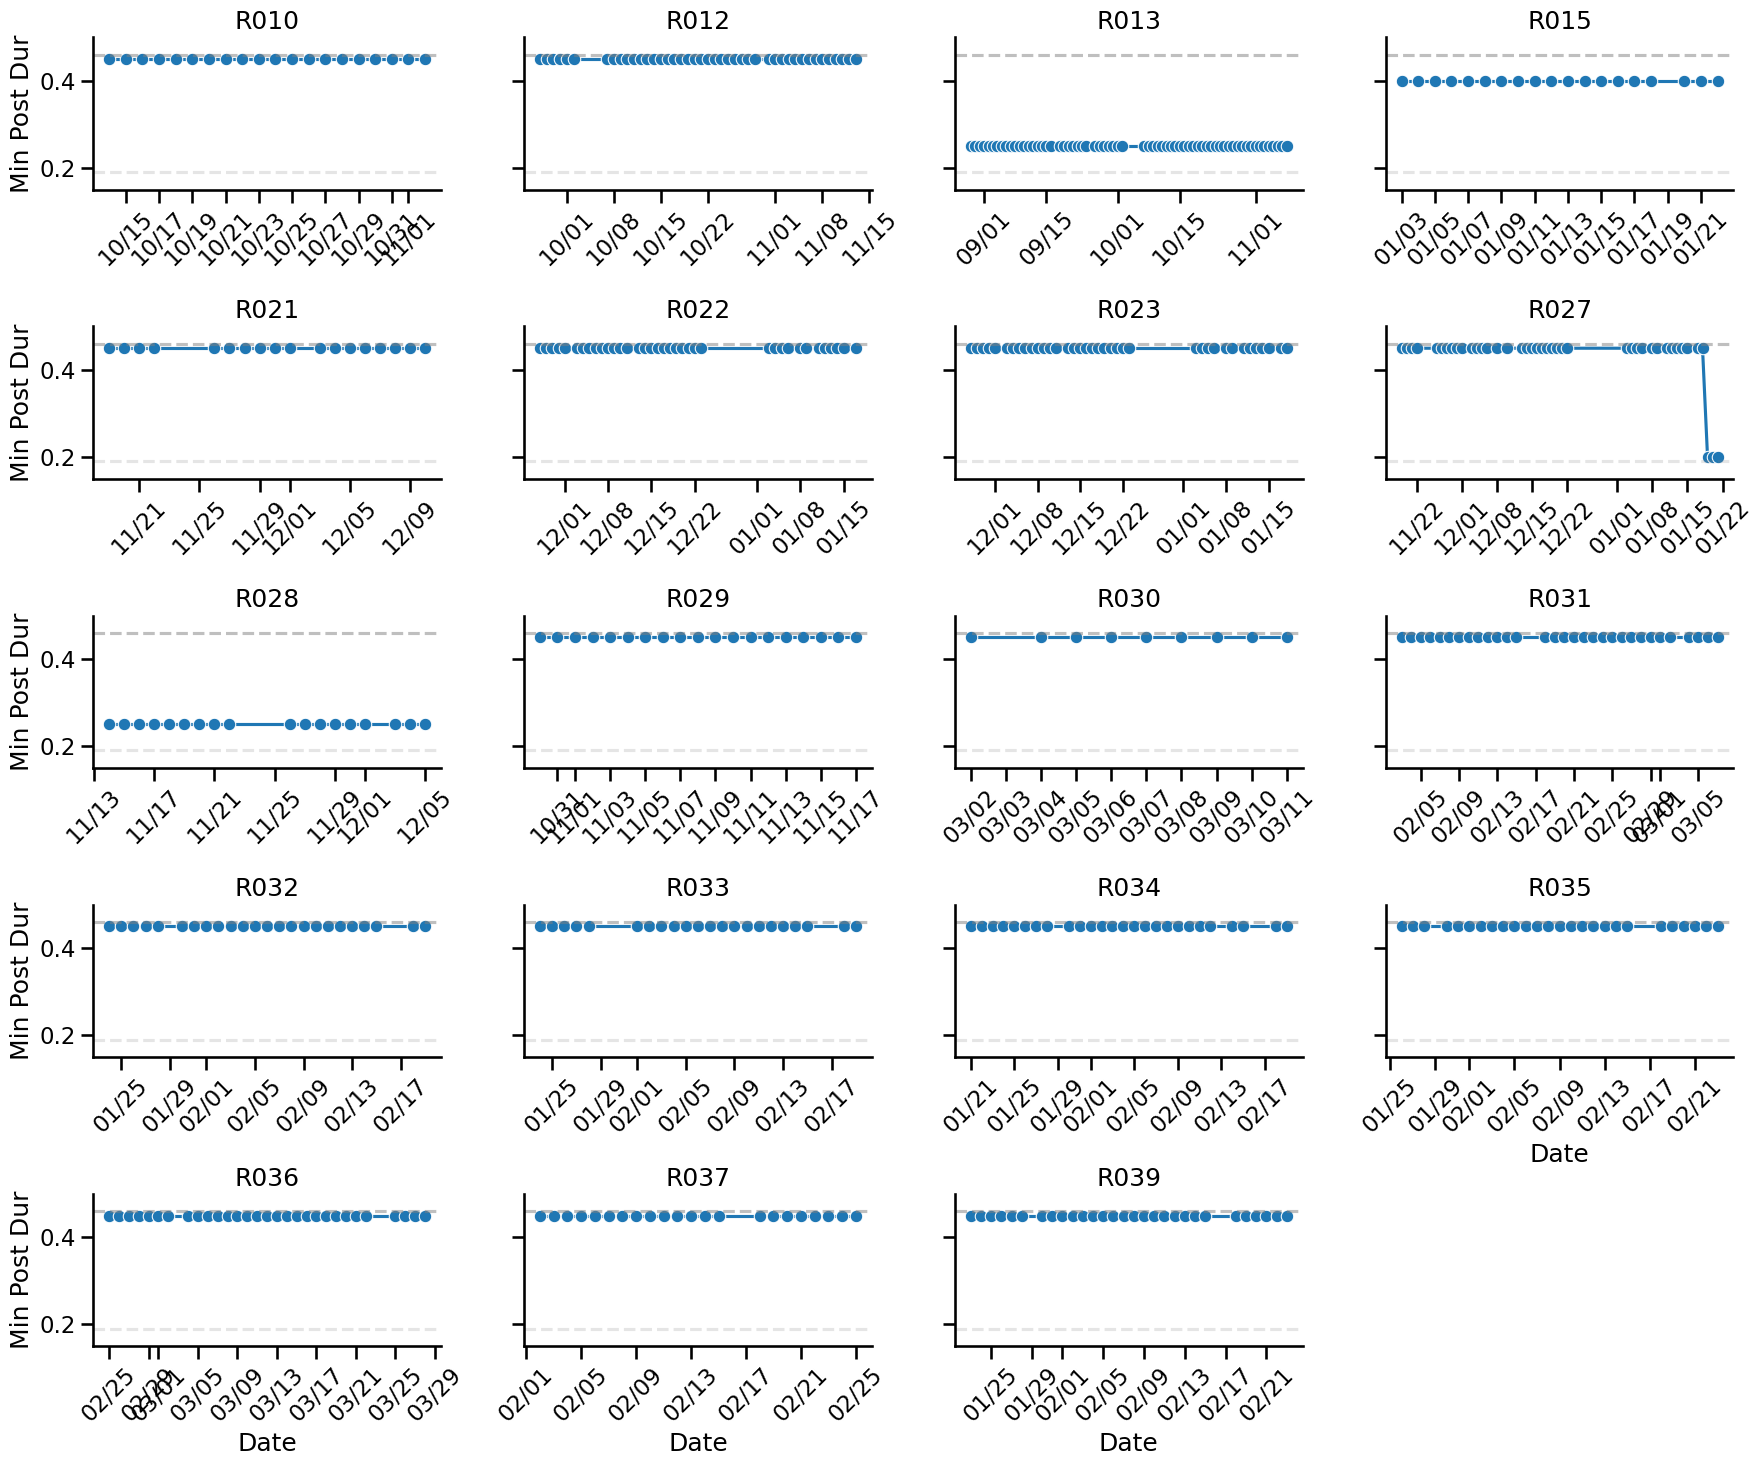

In [12]:
post_dur_df = (
    df_filtered
    .groupby(['animal_id', 'dt_date']).post_dur.min()
    .reset_index().rename(columns={"post_dur":"post_dur"})
)

g = sns.relplot(
    data=post_dur_df,
    x='dt_date',            # our datetime axis
    y='post_dur',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Min Post Dur")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.set_ylim(0.15, 0.50)        # set y-axis limits
    ax.axhline(0.46, color='gray', alpha=0.5, ls='--') 
    ax.axhline(0.19, color='gray', alpha=0.2, ls='--') 
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()

In [13]:
df_filtered = df_filtered.query("post_dur == 0.45")

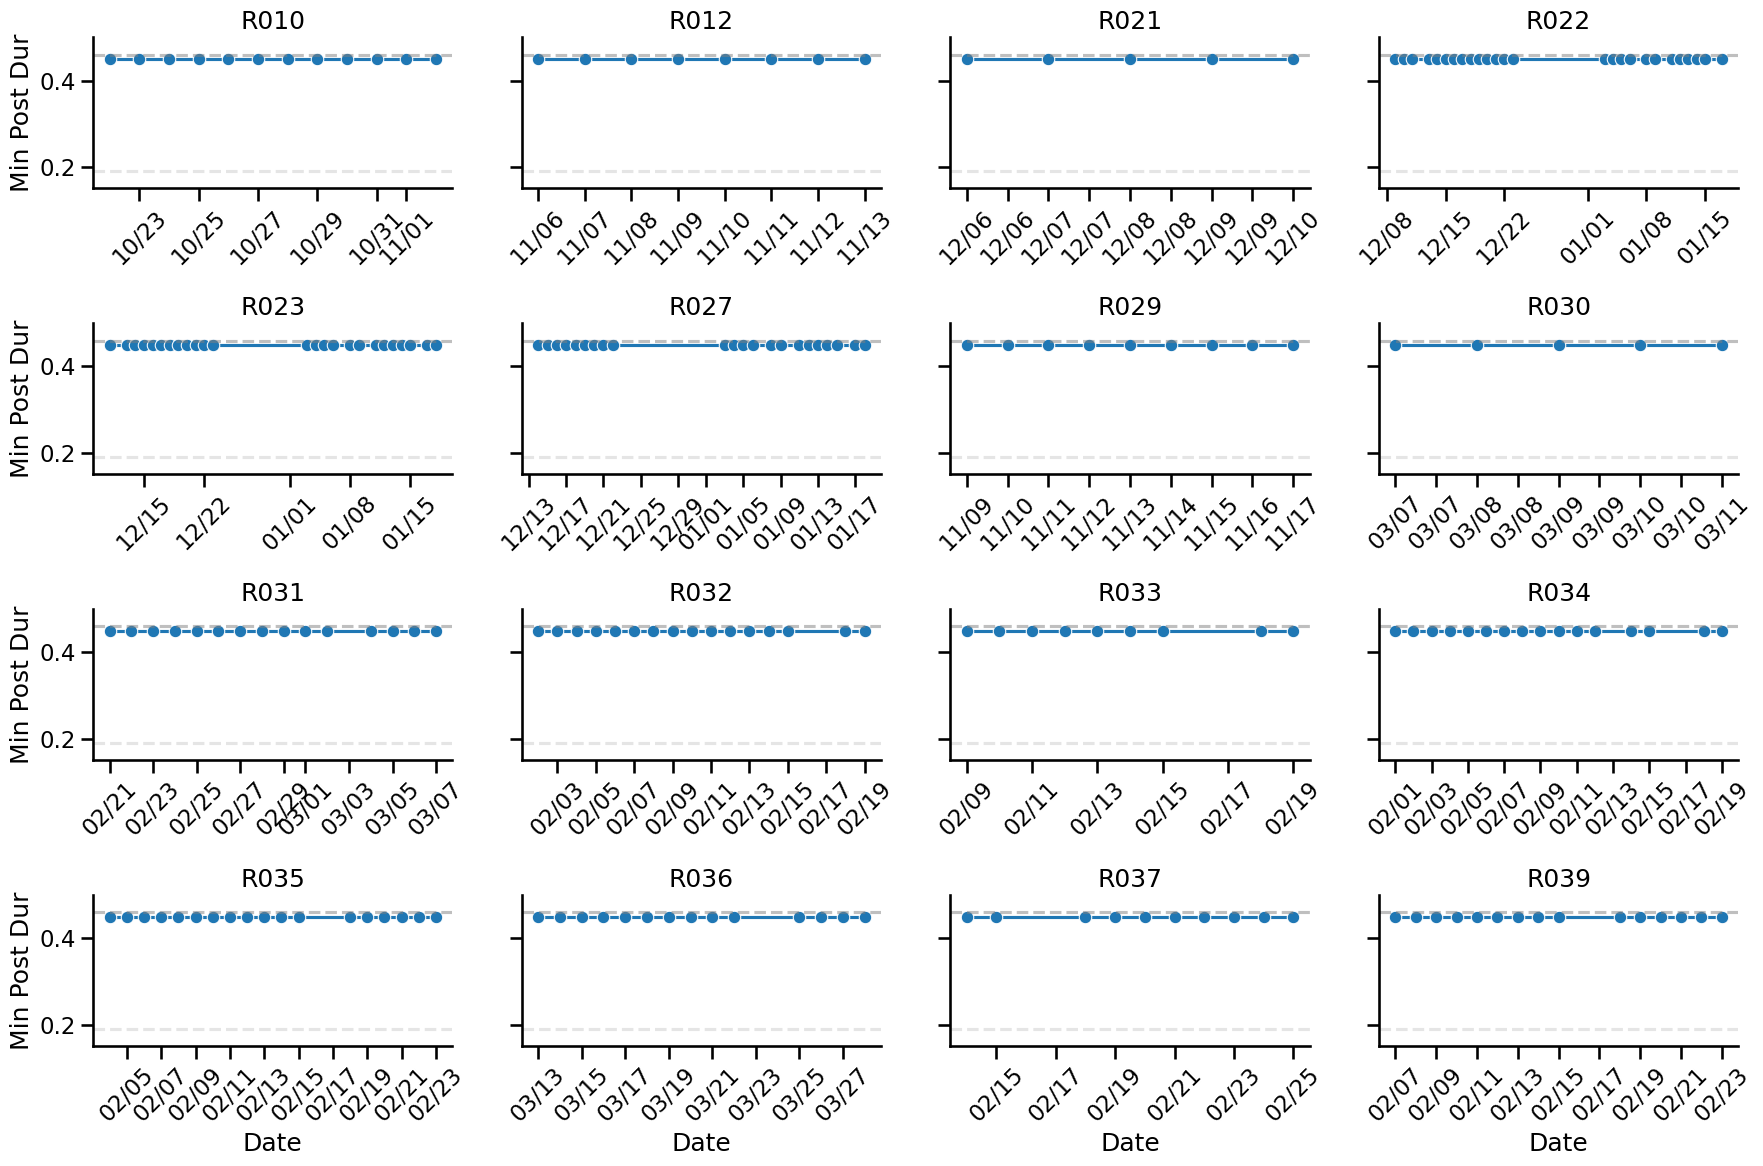

In [14]:
post_dur_df = (
    df_filtered.query("stage == 11")
    .groupby(['animal_id', 'dt_date']).post_dur.min()
    .reset_index().rename(columns={"post_dur":"post_dur"})
)

g = sns.relplot(
    data=post_dur_df,
    x='dt_date',            # our datetime axis
    y='post_dur',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Min Post Dur")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.set_ylim(0.15, 0.50)        # set y-axis limits
    ax.axhline(0.46, color='gray', alpha=0.5, ls='--') 
    ax.axhline(0.19, color='gray', alpha=0.2, ls='--') 
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()

## Viol Rates


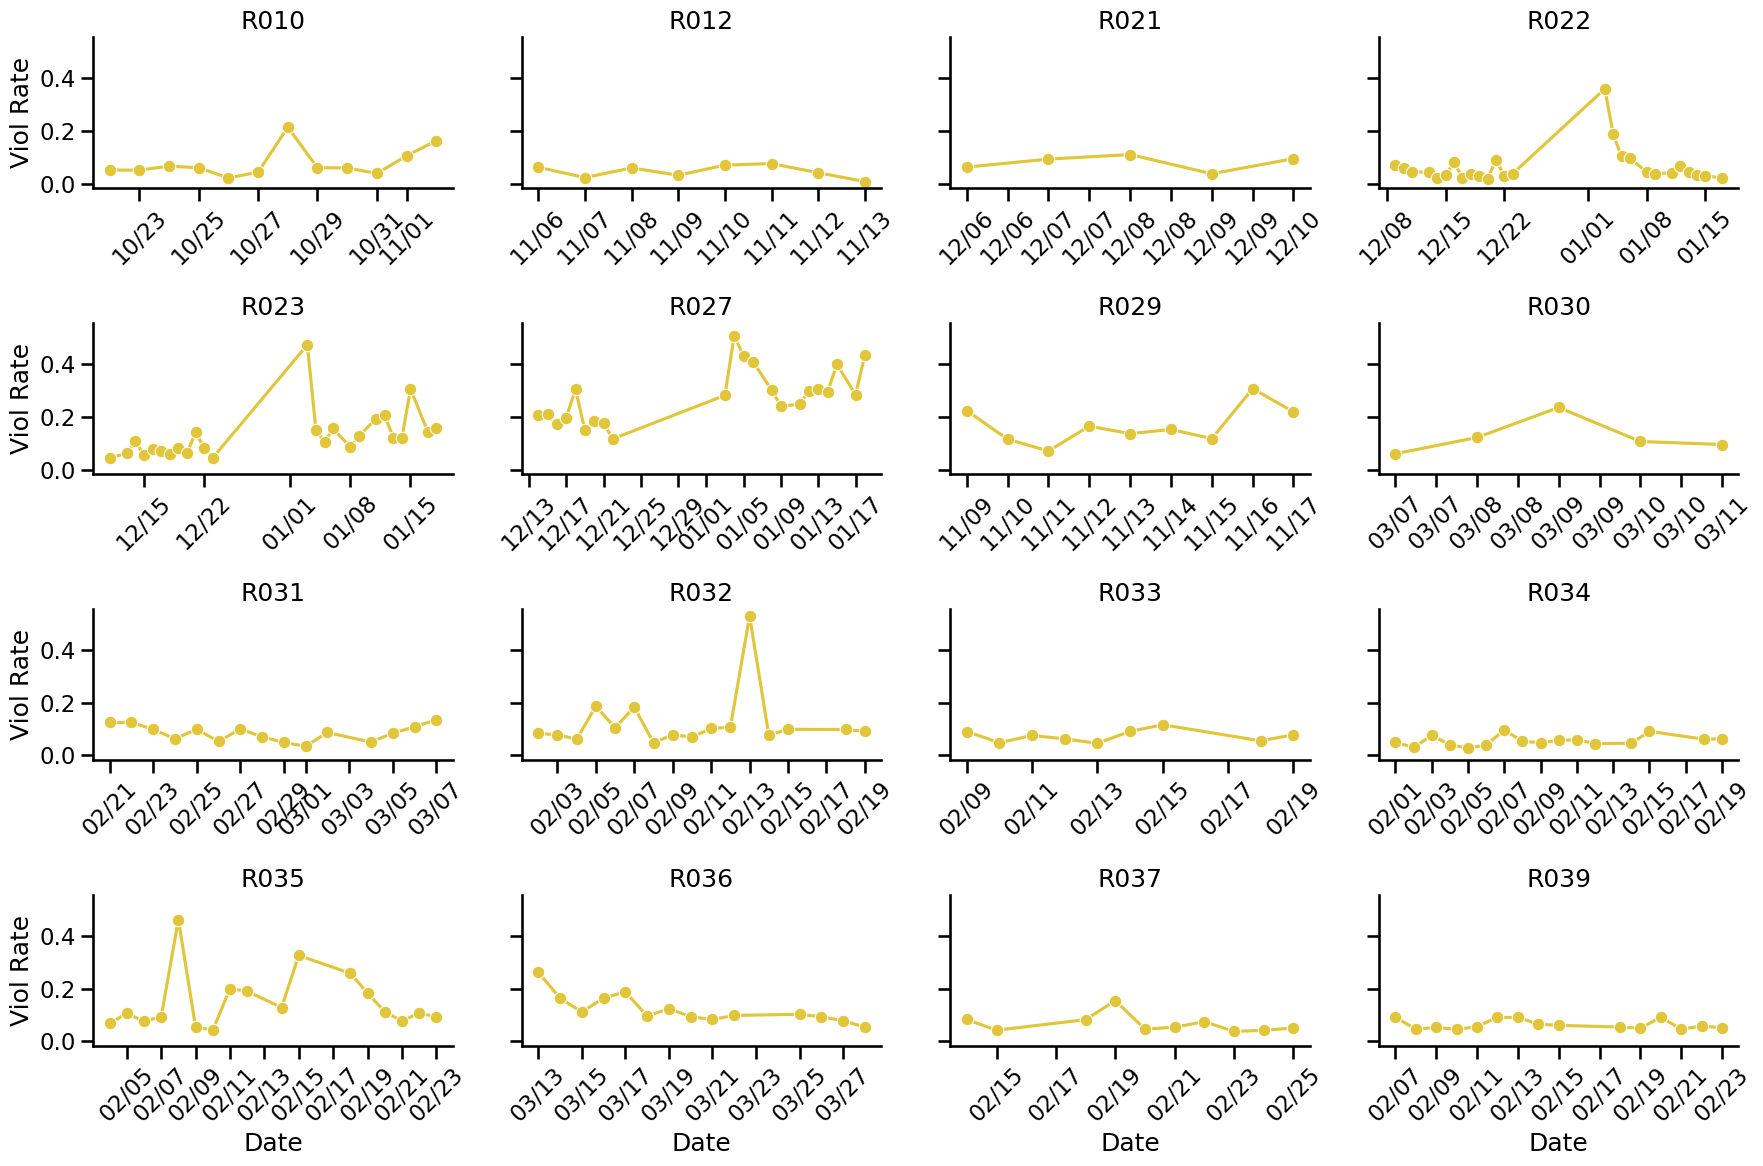

In [15]:
viol_rate_df = (
    df_filtered.query("stage == 11")
    .groupby(['animal_id', 'dt_date']).violations.mean()
    .reset_index().rename(columns={"violations":"viol_rate"})
)

g = sns.relplot(
    data=viol_rate_df.query("viol_rate < 0.9"),
    x='dt_date',            # our datetime axis
    y='viol_rate',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    col_wrap=4,          # max 3 columns → rows are added as needed
    color=c.VIOLATION_COLOR,
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Viol Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    # ax.set_ylim(0.15, 0.50)        # set y-axis limits
    # ax.axhline(0.46, color='gray', alpha=0.5, ls='--') 
    # ax.axhline(0.19, color='gray', alpha=0.2, ls='--') 
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()

## All durs


In [16]:
dur_cols = ["pre_dur", "stimulus_dur", "delay_dur", "post_dur", "viol_off_dur", "pre_go_dur"]

df_filtered[dur_cols].describe()

pre_dur  stimulus_dur     delay_dur      post_dur  viol_off_dur  \
count  71544.00       71544.0  71544.000000  7.154400e+04  71544.000000   
mean       0.25           0.4      0.150702  4.500000e-01      1.643295   
std        0.00           0.0      0.022133  1.110231e-16      0.083349   
min        0.25           0.4      0.150000  4.500000e-01      0.448000   
25%        0.25           0.4      0.150000  4.500000e-01      1.648000   
50%        0.25           0.4      0.150000  4.500000e-01      1.648000   
75%        0.25           0.4      0.150000  4.500000e-01      1.648000   
max        0.25           0.4      0.920470  4.500000e-01      2.420470   

         pre_go_dur  
count  71544.000000  
mean       1.650702  
std        0.022133  
min        1.650000  
25%        1.650000  
50%        1.650000  
75%        1.650000  
max        2.420470

# 5. Fixation Curriculum


In [17]:
VALID_ANIMALS = df_filtered.animal_id.unique().tolist()
exp_tdf = tdf.query("animal_id in @VALID_ANIMALS").copy()
exp_tdf['dt_date'] = pd.to_datetime(exp_tdf['date'])

## Stage 5-7 Fixation Growth

We want to remove any animals who didn't follow the V2 curriculum for growth to a specific target. Sometimes animals are so proficient at the task and the way the curriculum was originally written, they could move into stage 8 prior to reaching a specific fixation target


In [18]:
fixgrow_df = exp_tdf.query("stage >= 5 and stage <= 7").copy()
def determine_fixation_dur(row):
    if row["stage"] in (5, 6, 7, 8):
        if (
            row["session"] == 1 and row["cumulative_trial"] == 1
        ):  # pre go is sometimes set to 0.45
            return row.settling_in_dur
        else:
            return row.settling_in_dur + row.pre_go_dur
    elif row["stage"] >= 9:
        return row.pre_go_dur  # settling in dur now accounted for in pre_go_dur
    else:
        KeyError("Stage not found")


fixgrow_df["fixation_dur"] = fixgrow_df.apply(determine_fixation_dur, axis=1)

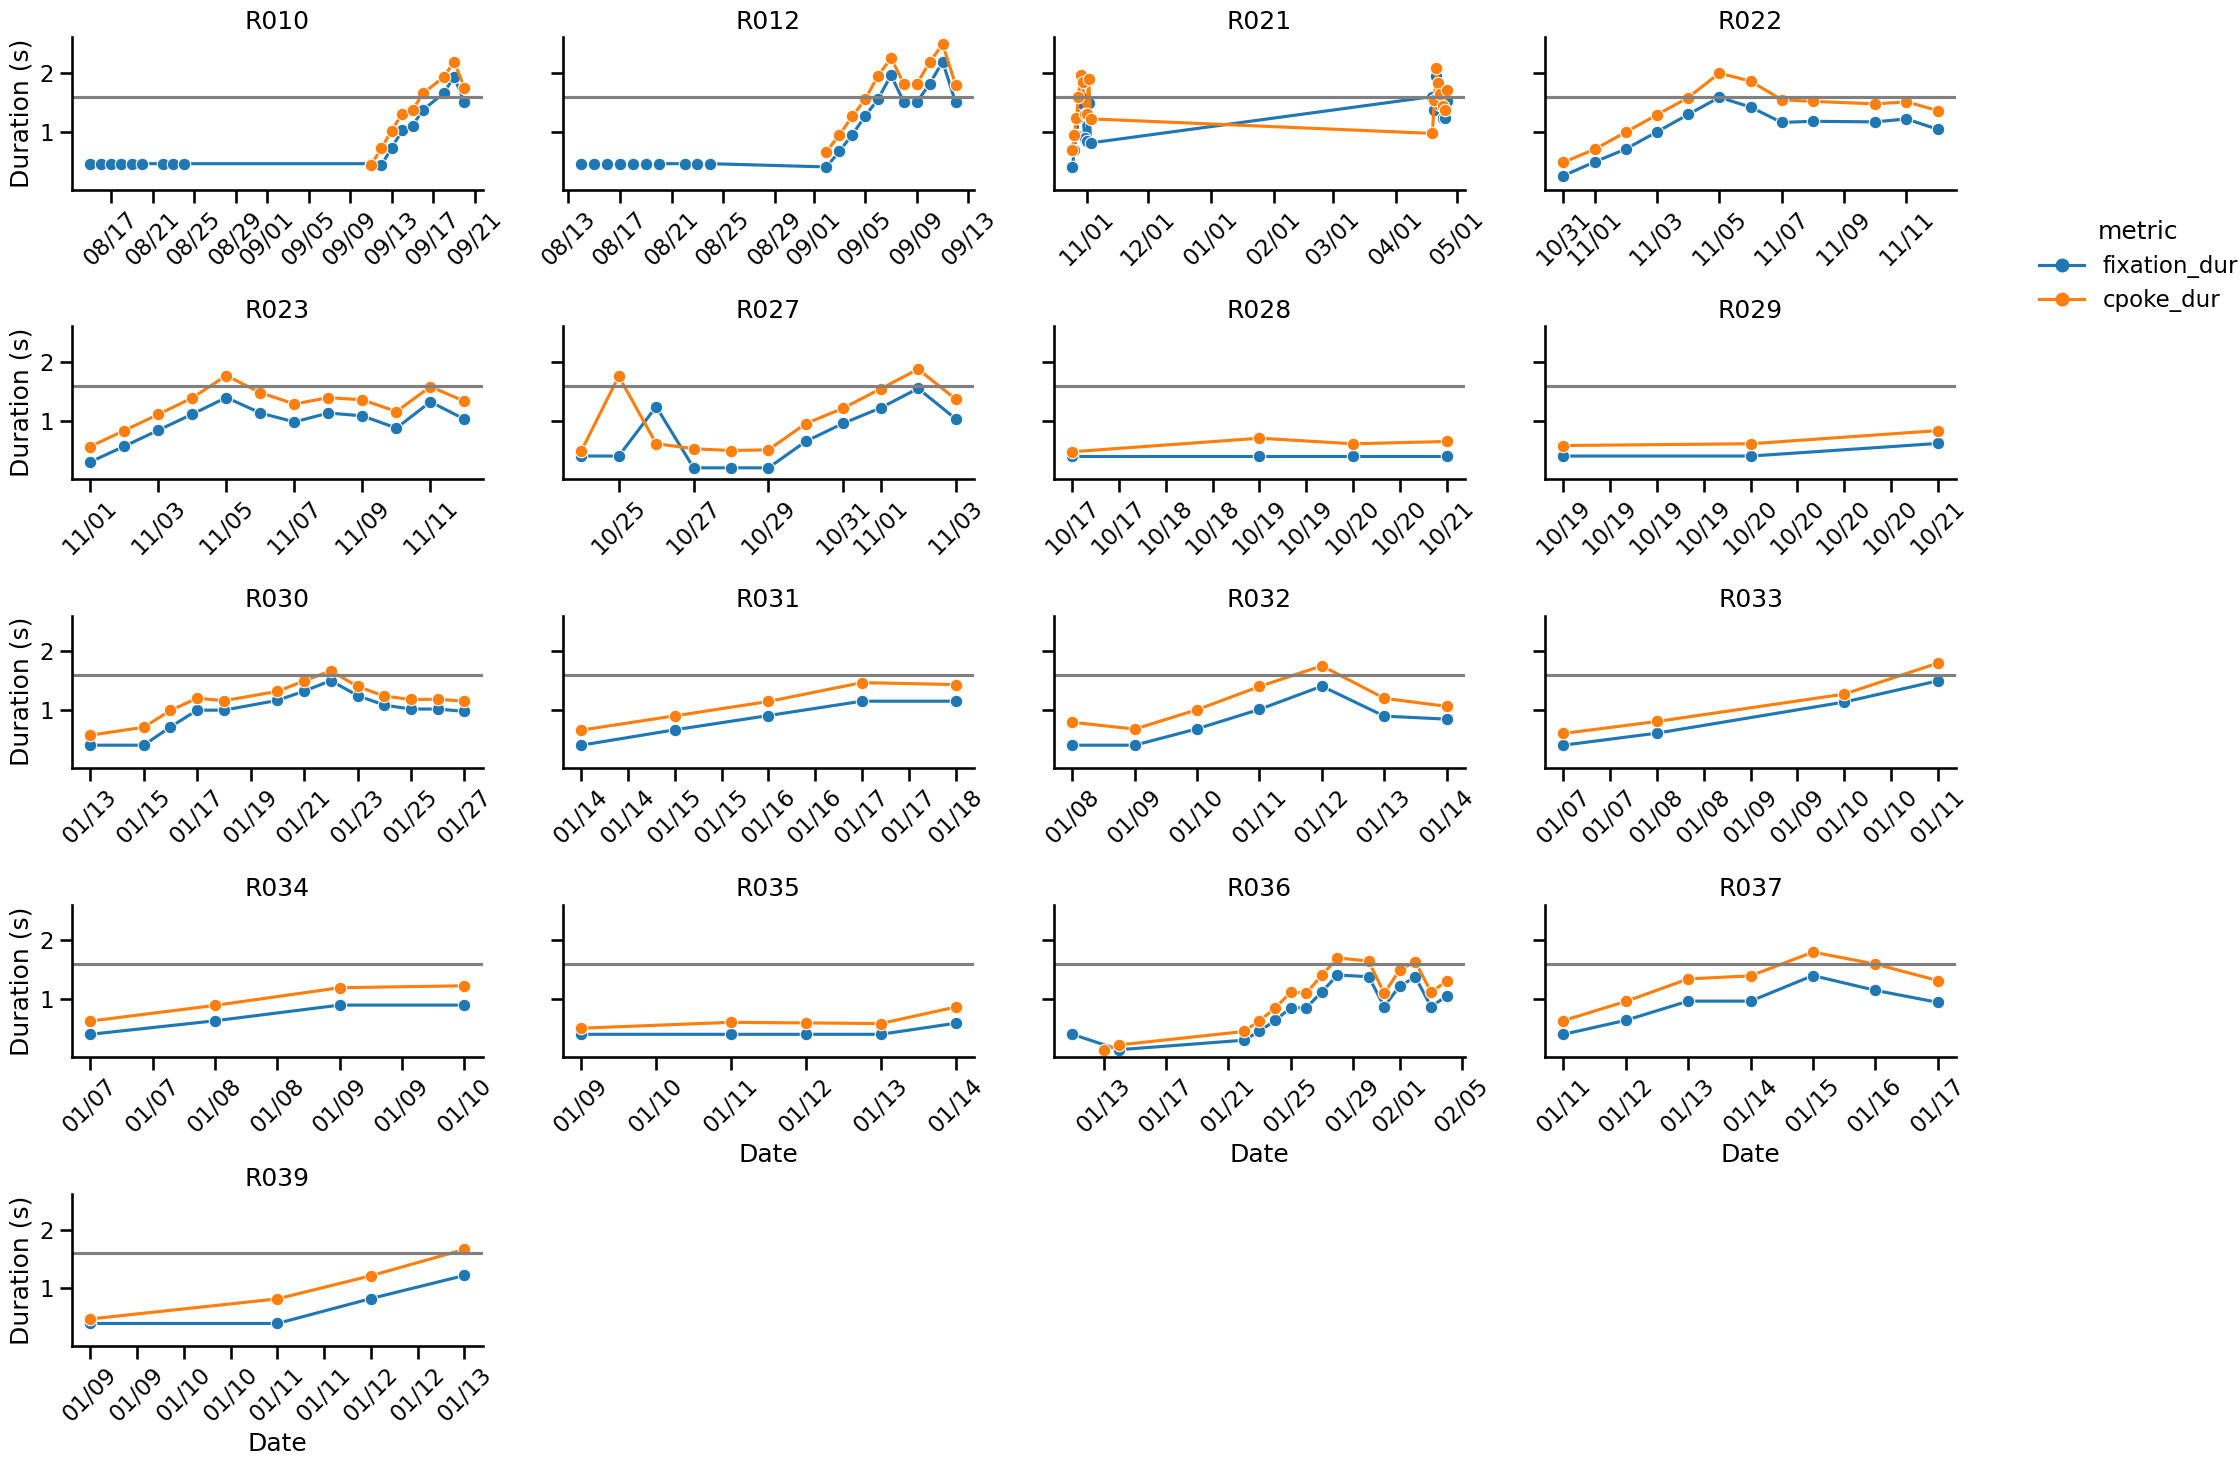

In [19]:

fix_val_df = (
    fixgrow_df
    .groupby(['animal_id', 'dt_date']).agg({'fixation_dur':'max', 'cpoke_dur':'mean'})
    .reset_index()
)
# 1. Melt to long form
df_long = (
    fix_val_df
    .melt(
        id_vars=['animal_id', 'dt_date'],
        value_vars=['fixation_dur','cpoke_dur'],
        var_name='metric',
        value_name='value'
    )
)

# 2. Single relplot with hue='metric'
g = sns.relplot(
    data=df_long,
    x='dt_date',
    y='value',
    hue='metric',            
    kind='line',
    col='animal_id',
    col_wrap=4,
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',
    height=3,
    aspect=1.5,
)

# 3. Beautify
g.set_axis_labels("Date", "Duration (s)")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.axhline(1.6, color='gray')
    ax.xaxis.set_major_formatter(
        plt.matplotlib.dates.DateFormatter("%m/%d")
    )
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
plt.tight_layout()

g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

In [20]:
# cut‐off dates for “keep only after”
after_cutoffs = {
    'R021': pd.Timestamp('2023-12-01'), # reset
}
# mask for those animals that need “> cutoff”
mask_after = (
    fixgrow_df['animal_id'].isin(after_cutoffs) &
    (fixgrow_df['dt_date'] > fixgrow_df['animal_id'].map(after_cutoffs))
)

# everyone else: no date filter
mask_other = ~fixgrow_df['animal_id'].isin(set(after_cutoffs))

# final filtered df
fixgrow_df_filtered = fixgrow_df[mask_after | mask_other]

INCOMPLETE_V2 = ['R028','R029', 'R034', 'R035']
fixgrow_df_filtered = fixgrow_df_filtered.query("animal_id not in @INCOMPLETE_V2")

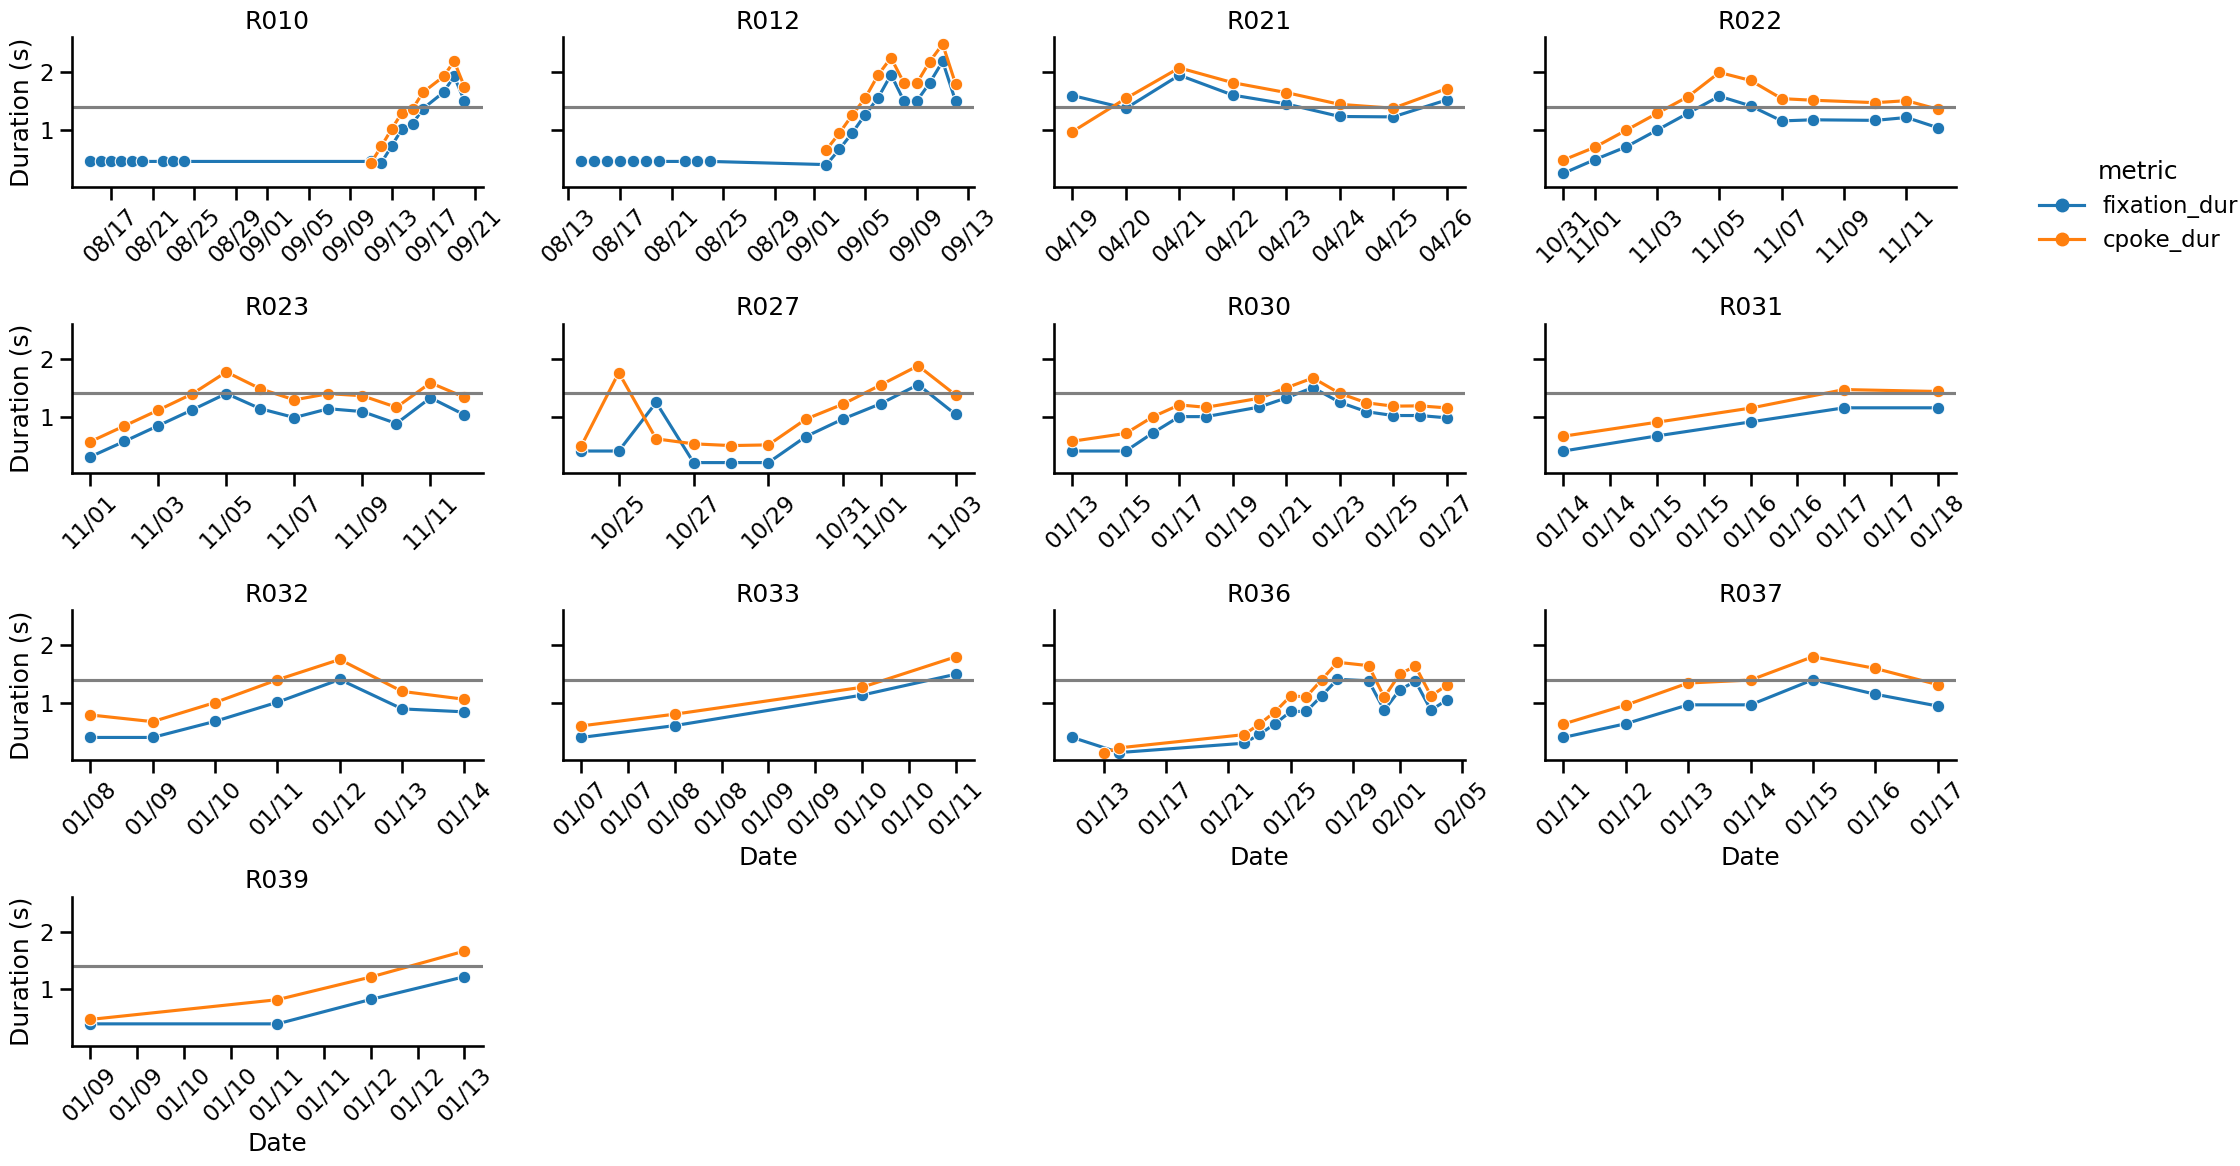

In [21]:


fix_val_df = (
    fixgrow_df_filtered
    .groupby(['animal_id', 'dt_date']).agg({'fixation_dur':'max', 'cpoke_dur':'mean'})
    .reset_index()
)
# 1. Melt to long form
df_long = (
    fix_val_df
    .melt(
        id_vars=['animal_id', 'dt_date'],
        value_vars=['fixation_dur','cpoke_dur'],
        var_name='metric',
        value_name='value'
    )
)

# 2. Single relplot with hue='metric'
g = sns.relplot(
    data=df_long,
    x='dt_date',
    y='value',
    hue='metric',              
    kind='line',
    col='animal_id',
    col_wrap=4,
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',
    height=3,
    aspect=1.5,
)

# 3. Beautify
g.set_axis_labels("Date", "Duration (s)")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.axhline(1.4, color='gray')
    ax.xaxis.set_major_formatter(
        plt.matplotlib.dates.DateFormatter("%m/%d")
    )
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
plt.tight_layout()

g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

Now we want to compute the number of days it took to grow to a specific fication target. We just need to get rid of the one way where R027 seemed to have a cpoke dur that was very long


In [22]:
mask = ~(
    (fix_val_df['animal_id'] == 'R027') &
    (fix_val_df['dt_date']    == '2023-10-25')
)
fix_val_df_filtered = fix_val_df[mask]

fix_val_df_filtered.animal_id.unique()

<StringArray>
['R010', 'R012', 'R021', 'R022', 'R023', 'R027', 'R030', 'R031', 'R032',
 'R033', 'R036', 'R037', 'R039']
Length: 13, dtype: string

In [23]:
# 2. Compute the threshold date Series
thresholds = (
    fix_val_df_filtered.loc[fix_val_df['cpoke_dur'] >= 1.45]
    .groupby('animal_id')['dt_date']
    .min()
)

# 2. map it back onto fix_val_df
fix_val_df['threshold_date'] = fix_val_df['animal_id'].map(thresholds)

# 3. filter in place
fix_target_df = fix_val_df[ fix_val_df['dt_date'] <= fix_val_df['threshold_date'] ].copy()

# 4. cleanup
# fix_target_df.drop(columns='threshold_date', inplace=True)

days_to_target = fix_target_df.groupby(['animal_id']).dt_date.nunique().reset_index().rename(columns={"dt_date":"n_days_fix_target"})

# add 1 extra day to n_days_fix_target for all animals and then another one for R027
days_to_target["adj_n_days_fix_target"] = days_to_target['n_days_fix_target'] + 1

days_to_target.loc[days_to_target['animal_id'] == 'R027', 'adj_n_days_fix_target'] += 1


In [24]:
days_to_target

animal_id  n_days_fix_target  adj_n_days_fix_target
0       R010                 15                     16
1       R012                 14                     15
2       R021                  2                      3
3       R022                  5                      6
4       R023                  5                      6
5       R027                  9                     11
6       R030                  7                      8
7       R031                  4                      5
8       R032                  5                      6
9       R033                  4                      5
10      R036                 11                     12
11      R037                  5                      6
12      R039                  4                      5

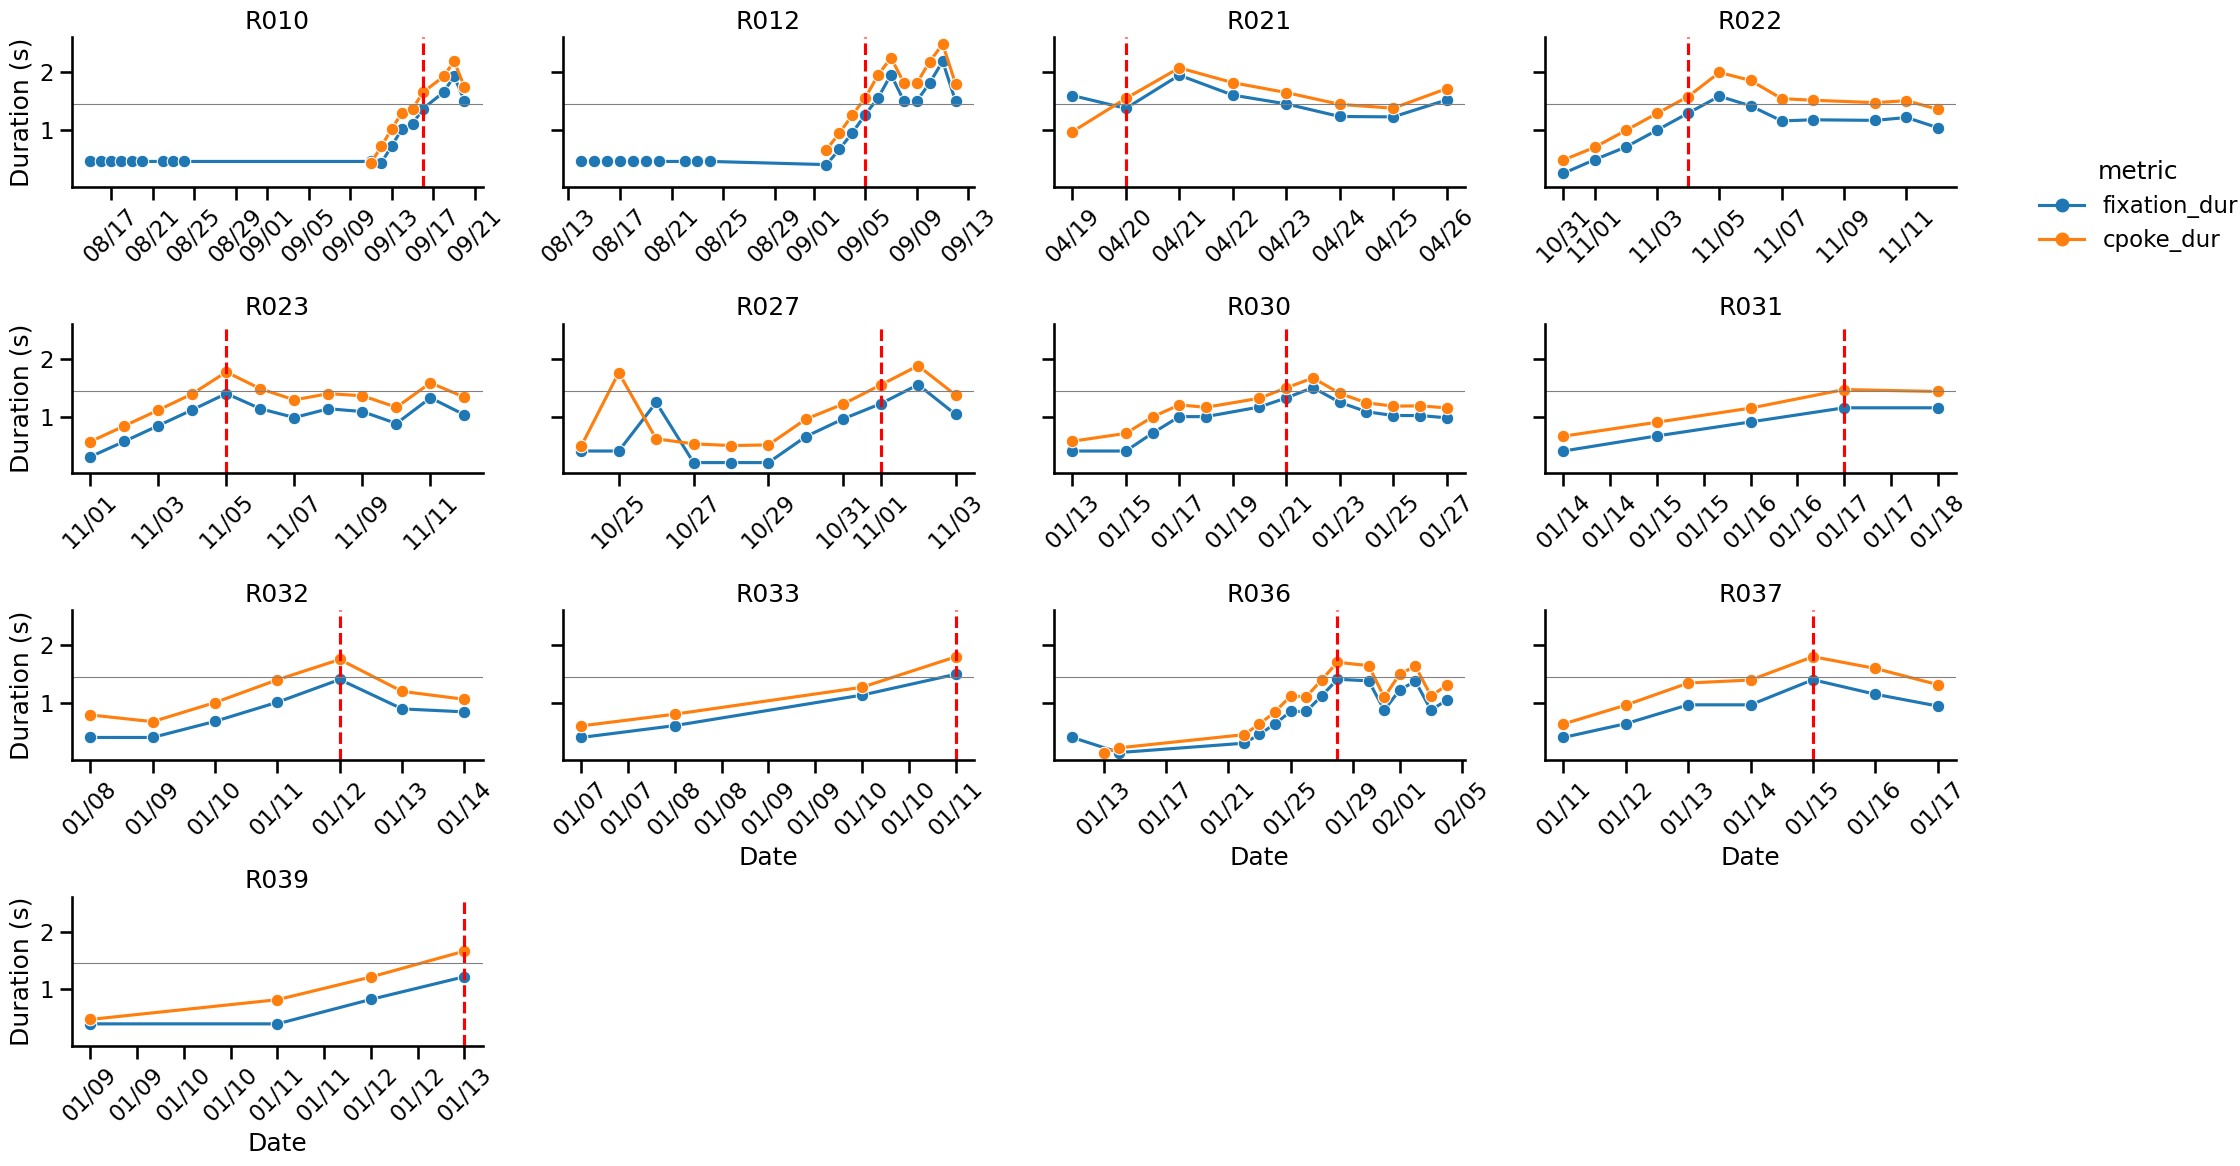

In [25]:
df_long = (
    fix_val_df
    .melt(
        id_vars=['animal_id', 'dt_date'],
        value_vars=['fixation_dur', 'cpoke_dur'],
        var_name='metric',
        value_name='value'
    )
)

g = sns.relplot(
    data=df_long,
    x='dt_date',
    y='value',
    hue='metric',
    kind='line',
    col='animal_id',
    col_wrap=4,
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',
    height=3,
    aspect=1.5,
)

import matplotlib.dates as mdates

# Beautify axes
g.set_axis_labels("Date", "Duration (s)")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    # get the animal_id from the facet title
    animal = ax.get_title()

    # look up the threshold date
    thresh_date = thresholds.get(animal, None)
    if pd.notnull(thresh_date):
        ax.axvline(thresh_date, color='red', linestyle='--', label='cpoke ≥ 1.45')

    
    ax.axhline(1.45, color='gray', linewidth=0.8)

    # format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)

# add a single legend entry for the vertical line
# (this puts it in the very first facet)
handles, labels = ax.get_legend_handles_labels()
if 'cpoke ≥ 1.5' in labels:
    g.axes.flatten()[0].legend([handles[labels.index('cpoke ≥ 1.45')]],
                               ['cpoke ≥ 1.45'], loc='upper left')

plt.tight_layout()
g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

In [26]:
days_to_target.adj_n_days_fix_target.describe().reset_index()

index  adj_n_days_fix_target
0  count              13.000000
1   mean               8.000000
2    std               4.143268
3    min               3.000000
4    25%               5.000000
5    50%               6.000000
6    75%              11.000000
7    max              16.000000

In [27]:
EXPERIMENT_ANIMALS = fix_val_df.animal_id.unique().tolist()

# 6. Training Times


## Stage 9- Add Sounds


In [28]:

exp_tdf = tdf.query("animal_id in @EXPERIMENT_ANIMALS").copy()
exp_tdf['dt_date'] = pd.to_datetime(exp_tdf['date'])

In [29]:
stg9_df = exp_tdf.query("stage == 9").groupby(["animal_id"]).date.nunique().reset_index().rename(columns={"date":"n_days_stage_9"})

stg9_df.n_days_stage_9.describe().reset_index()

index  n_days_stage_9
0  count       13.000000
1   mean        8.923077
2    std        1.754116
3    min        7.000000
4    25%        8.000000
5    50%        8.000000
6    75%        9.000000
7    max       13.000000

## Stage 10- Remove Light Guide


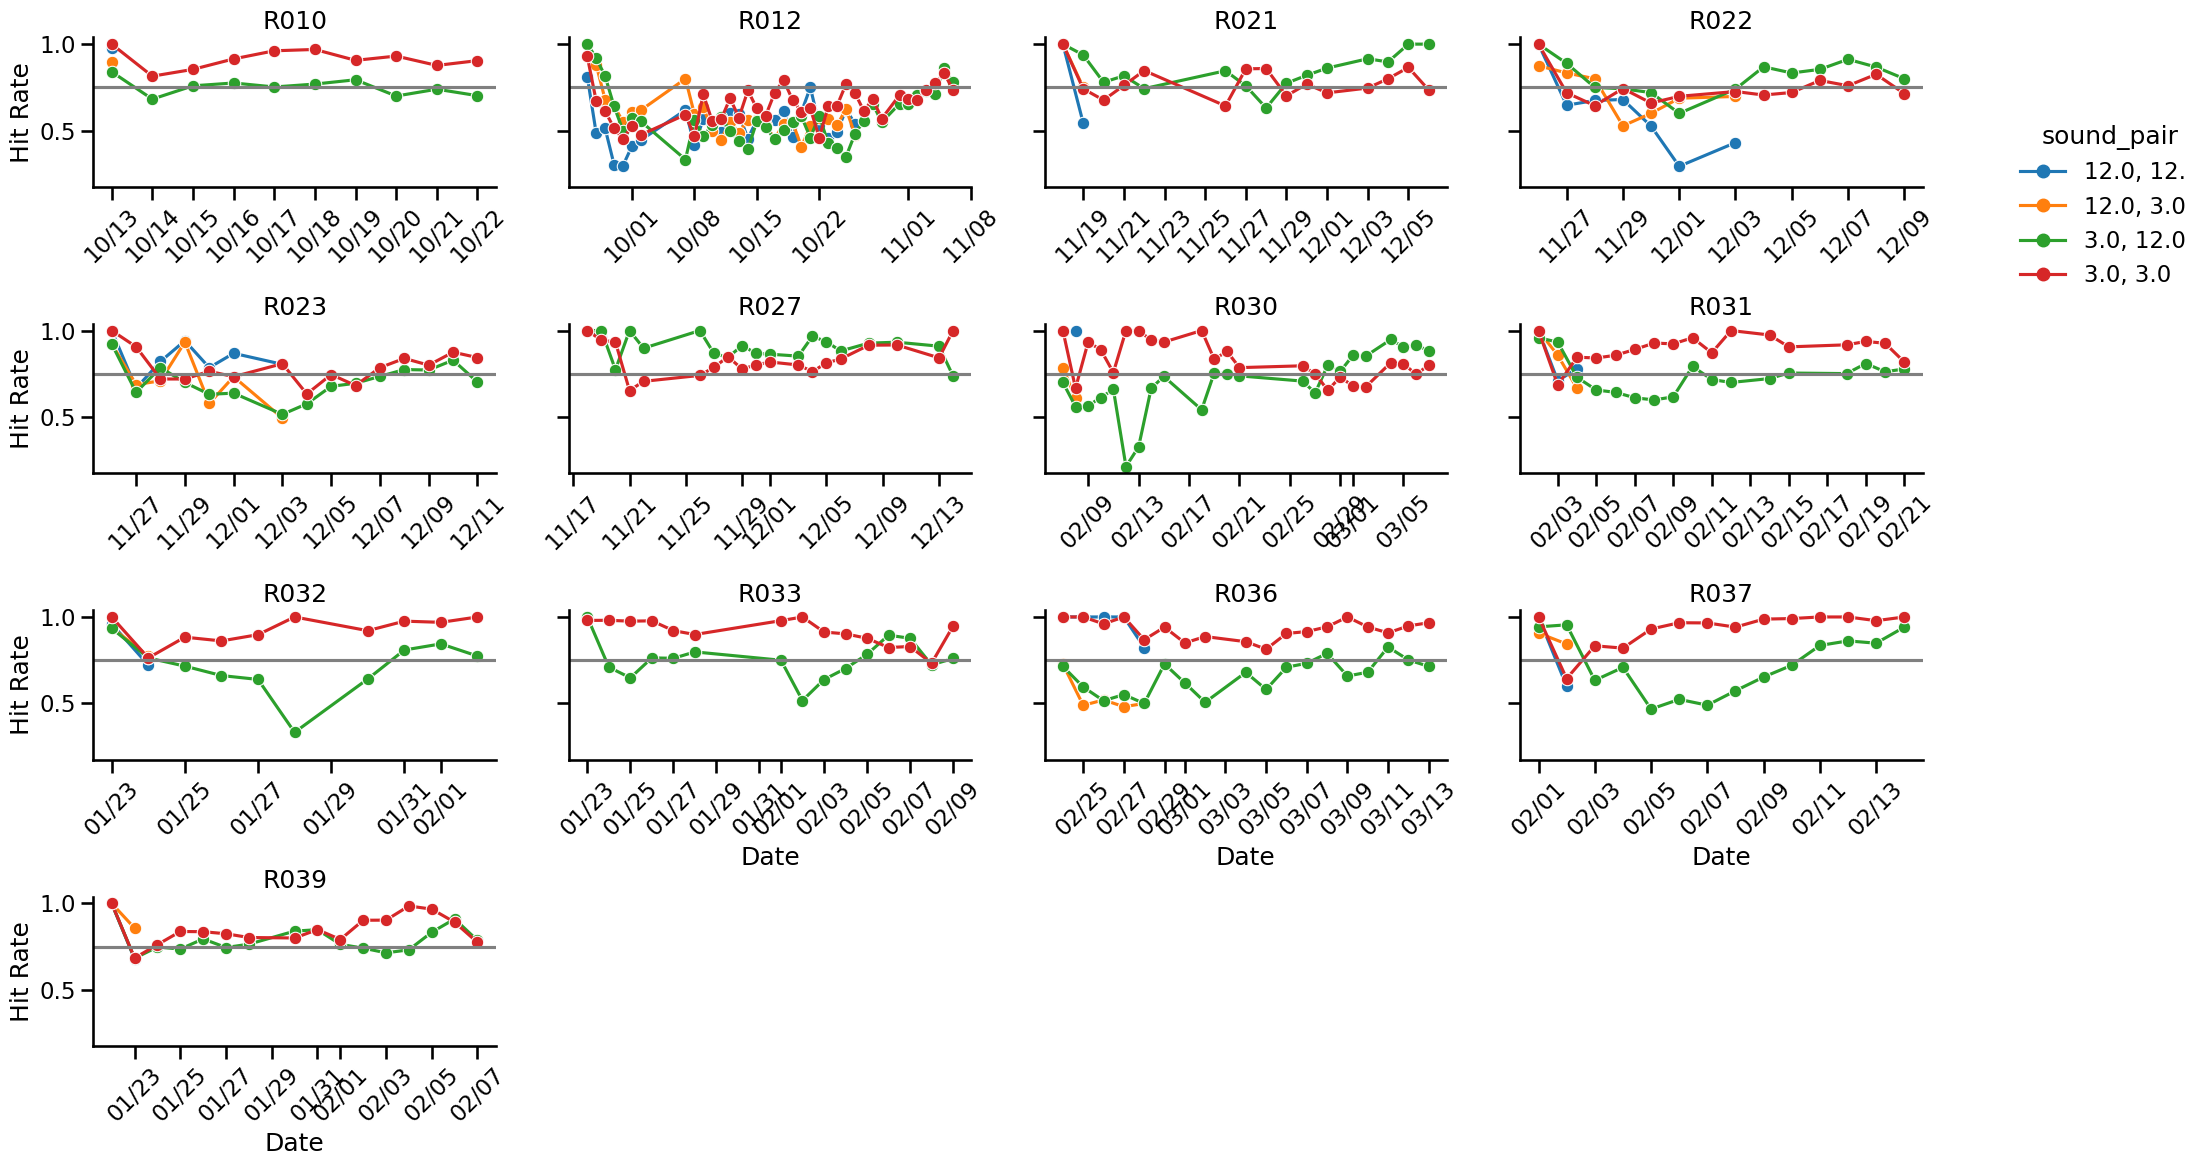

In [30]:

hit_rate_df = (
    exp_tdf.query("stage == 10")
    .groupby(['animal_id', 'dt_date', 'sound_pair']).hits.mean()
    .reset_index().rename(columns={"hits":"hit_rate"})
)

g = sns.relplot(
    data=hit_rate_df,
    x='dt_date',            # our datetime axis
    y='hit_rate',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    hue='sound_pair',
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Hit Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.axhline(0.75, color='gray') # add horizontal line at 0.75
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()

g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

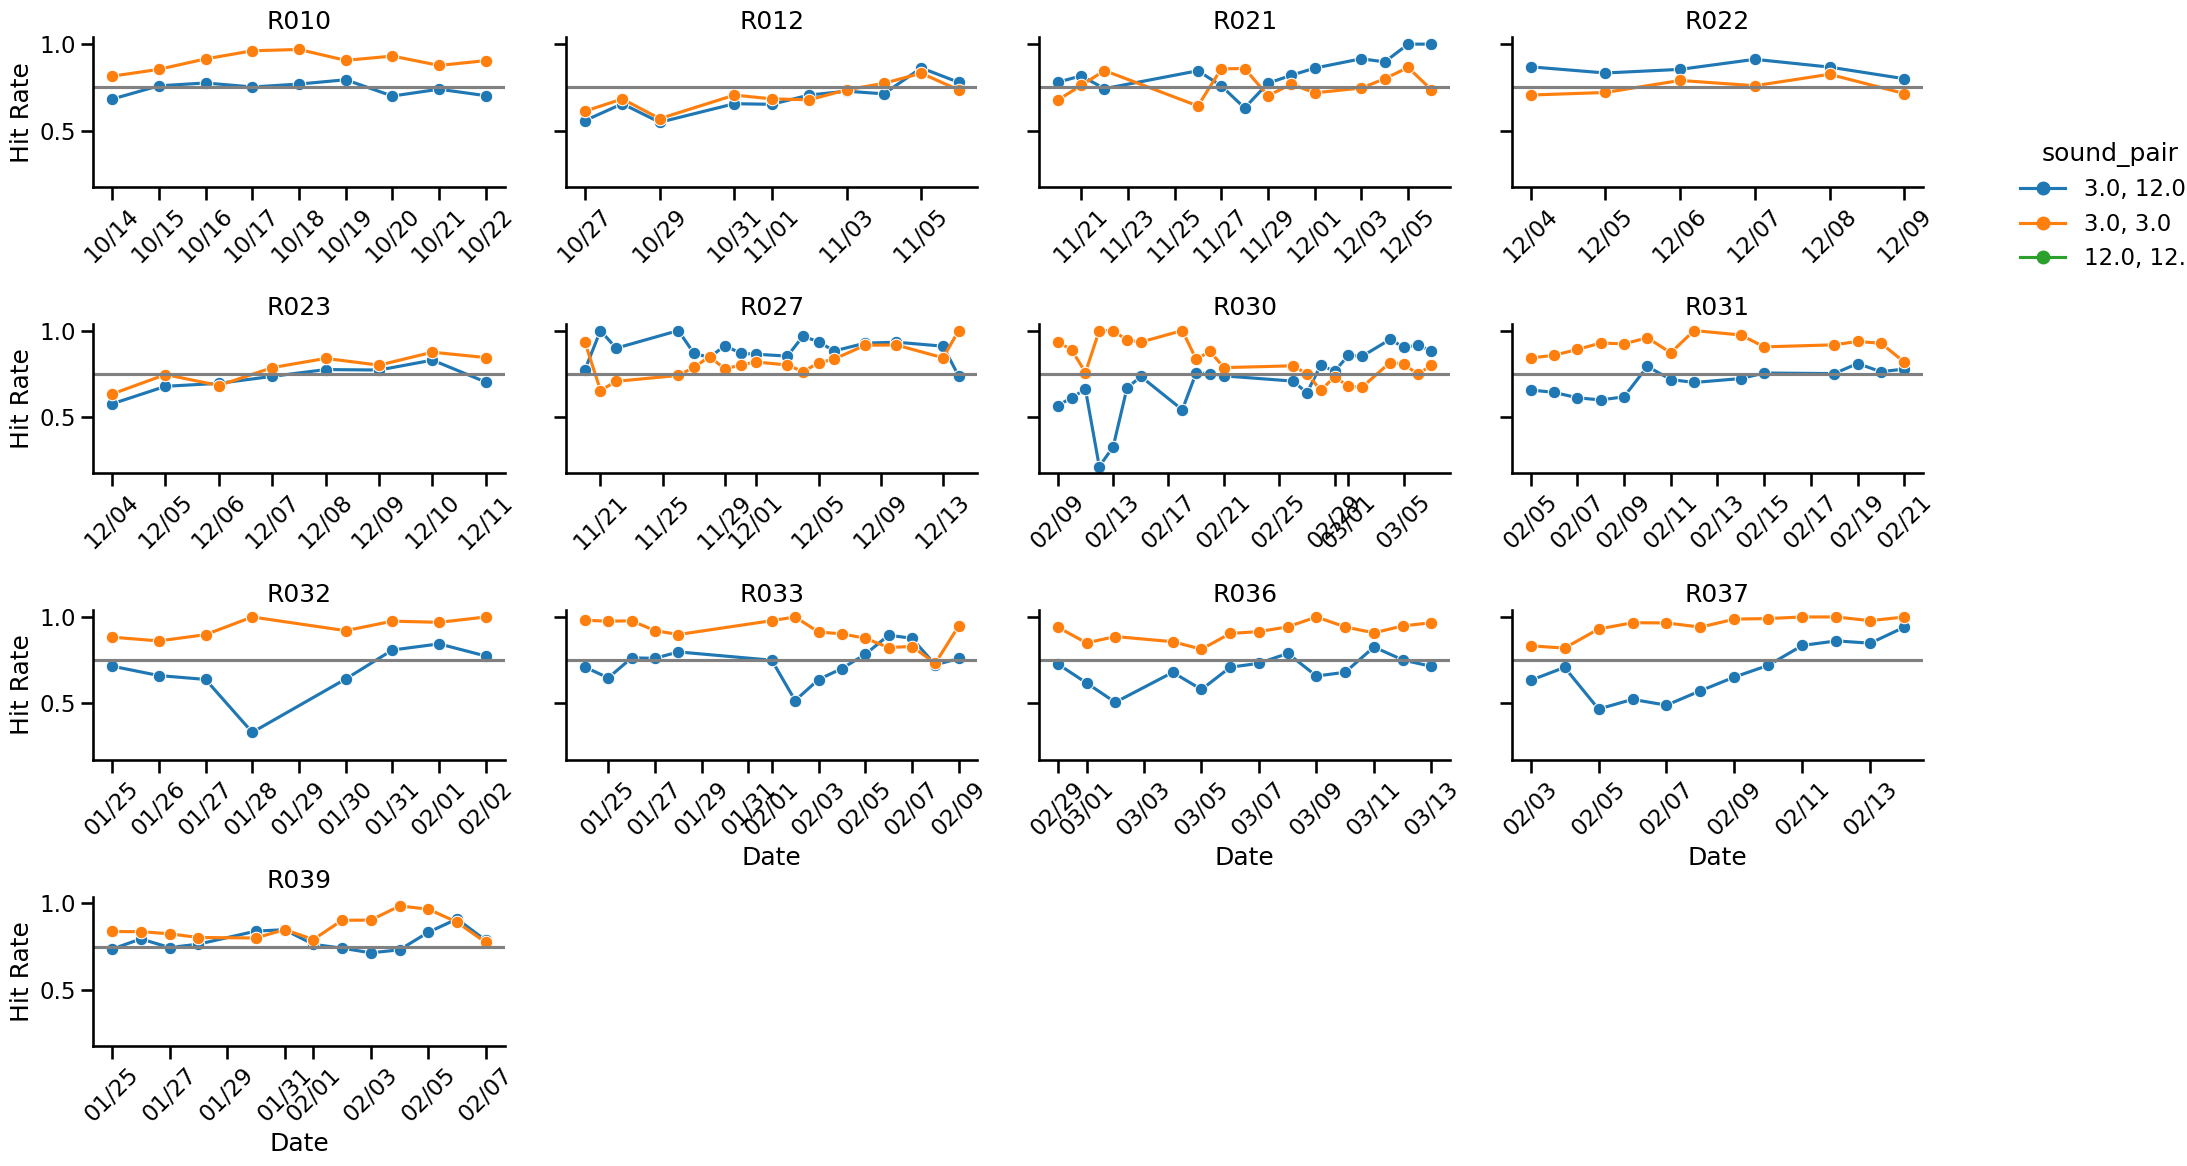

In [31]:

stg_10_filtered = ( # some animals got all 4 sound pairs, so we need to remove those sessions
    exp_tdf
    .query("stage == 10")
    .groupby(['animal_id','date'])
    .filter(lambda g: g.sound_pair.nunique() == 2)
)
hit_rate_df = (
    stg_10_filtered
    .groupby(['animal_id', 'dt_date', 'sound_pair']).hits.mean()
    .reset_index().rename(columns={"hits":"hit_rate"})
)

g = sns.relplot(
    data=hit_rate_df,
    x='dt_date',            # our datetime axis
    y='hit_rate',        # the value we want to plot
    kind='line',         # line plot
    col='animal_id',     # one facet per animal
    hue='sound_pair',
    col_wrap=4,          # max 3 columns → rows are added as needed
    facet_kws={'sharey': True, 'sharex': False},
    marker='o',          # show points
    height=3,            # height of each facet
    aspect=1.5,          # width = 1.5 × height
)

# Beautify:
g.set_axis_labels("Date", "Hit Rate")
g.set_titles("{col_name}")         # facet title = animal_id
for ax in g.axes.flatten():
    ax.axhline(0.75, color='gray') # add horizontal line at 0.75
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%m/%d"))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()

g._legend.set_bbox_to_anchor((1.0, 0.8))
g._legend.set_loc('center left')

In [32]:
stg10_df = stg_10_filtered.groupby(["animal_id"]).date.nunique().reset_index().rename(columns={"date":"n_days_stage_10"})

stg10_df.n_days_stage_10.describe().reset_index()


index  n_days_stage_10
0  count        13.000000
1   mean        12.307692
2    std         4.130872
3    min         6.000000
4    25%         9.000000
5    50%        13.000000
6    75%        14.000000
7    max        21.000000

# 7. Save out


In [33]:
# Session level Data
summary_df = df_filtered.query("animal_id in @EXPERIMENT_ANIMALS and stage == 11").groupby(['animal_id', 'dt_date']).agg({'violations':'mean', 'hits':'mean', 'trial':'count'}).reset_index()

summary_df = summary_df.query("violations < 0.9 and hits > 0.63")
summary_df["pct_correct"] = summary_df["hits"] * 100
summary_df["pct_viol"] = summary_df["violations"] * 100

summary_df.to_csv("data/DMStask_cleaned_summary_perf_df.csv", index=False)

In [34]:
# Trial level Data

df_filtered.query("animal_id in @EXPERIMENT_ANIMALS and stage == 11").to_csv("data/DMStask_cleaned_trials_df.csv", index=False)


In [35]:
# Fix growth data

days_to_target[['animal_id', 'adj_n_days_fix_target']].to_csv("data/DMStask_fixgrow_days_to_target.csv", index=False)